# **PROYECTO MACHINE LEARNING - JUAN ZUBIAGA**
### ELABORACIÓN DE UN MODELO DE CLASIFICACION PARA DESARROLLAR UNA HERRAMIENTA DE ANÁLISIS E INSPECCION DE LA SEGURIDAD DE UNA URL


# 1. IMPORTACIÓN DE LIBRERÍAS


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets,svm
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier 
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error,classification_report,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel,RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import uniform
import pickle
np.random.seed(0)
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier

# 2. IMPORTACION DE DATOS

In [2]:
pd.set_option('display.max_columns', None)
df=pd.read_csv('../data/Raw/phishing_Legitimate_full.csv').set_index('id')
df.head()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,5,72,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,21,44,0,0,0,0,0.000,0.250000,1,1,0,0,0,0.0,0,0,0,0,0,0,0,1,1,0,1,1,-1,1,1
2,3,1,3,144,0,0,0,0,2,0,2,1,0,41,1,0,0,0,0,0,17,16,103,0,1,0,0.000,0.000000,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,1,-1,1,1,1,1,1
3,3,1,2,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,27,24,0,0,0,0,0.375,1.000000,1,1,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,-1,1,-1,0,1
4,3,1,6,79,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,22,50,0,0,0,1,1.000,0.095238,1,1,0,0,0,0.0,1,0,0,0,1,0,0,0,1,-1,1,1,1,-1,1
5,3,0,4,46,0,0,0,0,0,0,0,0,0,2,1,1,0,0,1,0,10,29,0,0,0,0,1.000,1.000000,0,0,0,1,0,0.0,1,0,0,0,0,1,0,0,1,1,-1,0,-1,-1,1


In [3]:
df.columns

Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT

## 2.1 SIGNIFICADO DE LAS VARIABLES   
Atendiendo a los nombres y abreviaturas de las variables, cabe incluir una breve definición de lo que cada variable significa. Se agrupan en tres tipos:

#### ***A. VARIABLES RELACIONADAS CON LA ESTRUCTURA DEL ENLACE:***   

- NumDots: Número de puntos (.) en la URL. Los sitios de phishing a menudo usan varios subdominios y puntos para intentar confundir al usuario.

- SubdomainLevel: Nivel del subdominio en la URL. Los dominios de phishing suelen usar múltiples subdominios.

- PathLevel: Número de niveles en el "path" de la URL, es decir, cuántos directorios o rutas hay después del dominio.

- UrlLength: Longitud total de la URL. Las URL de phishing suelen ser más largas, con cadenas complejas.

- NumDash: Número de guiones (-) en la URL. Un número excesivo de guiones podría ser sospechoso.

- NumDashInHostname: Número de guiones en el nombre del host (parte del dominio antes del ".com", ".org", etc.). En algunos casos, los sitios de phishing usan guiones para simular dominios legítimos.

- AtSymbol: Presencia del símbolo "@" en la URL, lo cual puede ser un intento de ofuscar el dominio.

- TildeSymbol: Número de símbolos de tilde (~) en la URL. Algunos sitios de phishing los usan para hacer la URL más difícil de leer.

- NumUnderscore: Número de guiones bajos (_) en la URL. Los guiones bajos son menos comunes en URLs legítimas y pueden ser indicativos de un intento de fraude.

- NumPercent: Número de símbolos de porcentaje (%), que a menudo se usan para codificar caracteres en URLs.

- NumQueryComponents: Número de componentes en la consulta (por ejemplo, parámetros como "?id=123&name=abc"). Los sitios de phishing pueden tener múltiples parámetros.

- NumAmpersand: Número de símbolos "&" que separan los componentes de una consulta en la URL.

- NumHash: Número de signos de número (#), que pueden estar relacionados con anclas en la URL.

- NumNumericChars: Número de caracteres numéricos en la URL. Los números pueden ser un indicio de que una URL ha sido generada automáticamente.

- NoHttps: Indicador binario de si la URL no utiliza HTTPS, lo que significa que la conexión no es segura. Las páginas de phishing generalmente no usan HTTPS.

- RandomString: Número de caracteres aleatorios en la URL, que pueden ser generados automáticamente en sitios de phishing para dar la apariencia de ser un sitio legítimo.

- IpAddress: Si la URL contiene una dirección IP en lugar de un nombre de dominio. Las direcciones IP a menudo son un signo de un sitio de phishing.

- DomainInSubdomains: Si el dominio principal está presente dentro de los subdominios. Los sitios de riesgo pueden usar dominios que contienen el nombre de un sitio legítimo.

- DomainInPaths: Si el dominio aparece en la ruta de la URL. Algunos sitios de phishing intentan disimularse al incluir el nombre del dominio en la ruta.

- HttpsInHostname: Si la palabra "https" aparece en el nombre del host. Algunos sitios de phishing intentan simular sitios seguros al incluir "https" en el nombre de dominio, aunque el sitio no sea seguro.

- HostnameLength: Longitud del nombre del host (dominio). Los sitios de phishing a menudo usan nombres largos y complejos.

- PathLength: Longitud de la ruta (path) de la URL.

- QueryLength: Longitud de la consulta (query) en la URL.

- DoubleSlashInPath: Si hay doble barra (//) en la ruta, lo que puede ser un signo de que la URL es maliciosa.


#### ***B. VARIABLES RELACIONADAS CON EL CONTENIDO DE LA WEB (DESTINO DEL ENLACE):***   

- NumSensitiveWords: Número de palabras sensibles (como "bank", "login", "password") en la URL. Los sitios de phishing suelen usar este tipo de palabras para atraer a los usuarios.

- EmbeddedBrandName: Si el nombre de una marca conocida (como "paypal", "google", etc.) está incrustado en la URL.

- PctExtHyperlinks: Porcentaje de enlaces externos en la página, lo que puede ser una señal de que el sitio está tratando de redirigir a los usuarios a otros sitios de phishing.

- PctExtResourceUrls: Porcentaje de URLs que hacen referencia a recursos externos (como imágenes, scripts...).

- ExtFavicon: Si la URL tiene un favicon (icono en la pestaña del navegador) de un dominio diferente, lo que podría ser indicativo de una página de phishing.

- InsecureForms: Si hay formularios inseguros en la página, como formularios de inicio de sesión sin HTTPS.

- RelativeFormAction: Si el formulario tiene una acción relativa (es decir, no incluye un dominio completo), lo que puede ser sospechoso.

- ExtFormAction: Si el formulario redirige a un dominio externo, lo cual es común en los ataques de phishing.

- AbnormalFormAction: Si la acción del formulario es inusual o sospechosa.

- PctNullSelfRedirectHyperlinks: Porcentaje de enlaces que redirigen a la misma página sin ninguna razón clara, lo que puede ser un signo de un ataque de phishing.

- FrequentDomainNameMismatch: Si hay discrepancias frecuentes entre el dominio y el nombre real de la página.

- FakeLinkInStatusBar: Si hay un enlace falso en la barra de estado del navegador, lo cual es un signo de phishing.

- RightClickDisabled: Si el clic derecho está deshabilitado en la página, lo que a menudo se utiliza para evitar que los usuarios vean el código fuente de la página.

- PopUpWindow: Si la página utiliza ventanas emergentes (pop-ups), que pueden ser una táctica de phishing.

- SubmitInfoToEmail: Si el formulario en la página envía la información a un correo electrónico, lo que es una señal de phishing.

- IframeOrFrame: Si la página utiliza un iframe o un frame, lo que puede ser un intento de ocultar la verdadera URL.

- MissingTitle: Si la página web no tiene un título (lo cual es inusual en sitios legítimos).

- ImagesOnlyInForm: Si solo hay imágenes dentro de los formularios en lugar de texto, lo que podría ser una señal de phishing.


#### ***C. VARIABLES RELACIONADAS CON LOS DATOS DEL ENLACE Y SU TRANSFORMACIÓN:***   

- SubdomainLevelRT: Transformación o variación del número de subdominios.

- UrlLengthRT: Transformación o variación de la longitud de la URL.

- PctExtResourceUrlsRT: Variación en el porcentaje de recursos externos.

- AbnormalExtFormActionR: Transformación de la acción del formulario que puede ser anómala.

- ExtMetaScriptLinkRT: Variación relacionada con enlaces de metadatos o scripts externos.

- PctExtNullSelfRedirectHyperlinksRT: Variación del porcentaje de enlaces que redirigen sin una razón clara.

- **CLASS_LABEL: La etiqueta objetivo, donde 1 indica que la URL es peligrosa y 0 indica que es legítima.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   NumDots                             10000 non-null  int64  
 1   SubdomainLevel                      10000 non-null  int64  
 2   PathLevel                           10000 non-null  int64  
 3   UrlLength                           10000 non-null  int64  
 4   NumDash                             10000 non-null  int64  
 5   NumDashInHostname                   10000 non-null  int64  
 6   AtSymbol                            10000 non-null  int64  
 7   TildeSymbol                         10000 non-null  int64  
 8   NumUnderscore                       10000 non-null  int64  
 9   NumPercent                          10000 non-null  int64  
 10  NumQueryComponents                  10000 non-null  int64  
 11  NumAmpersand                        10000 non-

Como se explica más adelante, en los modelos definitivos y su aplicación en Streamlit solo se van a utilizar las variables relativas a la estructura del propio URL, por lo que conviene crear, para una mejor visualizacion de sus datos, una fracción del dataset original manteniendo unicamente esas variables.

In [5]:
df2=df.copy()
df.drop(columns=['NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT'],inplace=True)
df2

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,5,72,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,21,44,0,0,0,0,0.000000,0.250000,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,1,1,0,1,1,-1,1,1
2,3,1,3,144,0,0,0,0,2,0,2,1,0,41,1,0,0,0,0,0,17,16,103,0,1,0,0.000000,0.000000,0,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,-1,1,1,1,1,1
3,3,1,2,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,27,24,0,0,0,0,0.375000,1.000000,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,0,-1,1,-1,0,1
4,3,1,6,79,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,22,50,0,0,0,1,1.000000,0.095238,1,1,0,0,0,0.000000,1,0,0,0,1,0,0,0,1,-1,1,1,1,-1,1
5,3,0,4,46,0,0,0,0,0,0,0,0,0,2,1,1,0,0,1,0,10,29,0,0,0,0,1.000000,1.000000,0,0,0,1,0,0.000000,1,0,0,0,0,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,3,1,1,50,0,0,0,0,0,0,2,1,0,9,1,0,0,0,0,0,15,10,17,0,0,0,0.096774,0.757143,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,1,-1,1,0,1,0
9997,2,1,4,59,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,19,33,0,0,0,0,0.161290,0.275862,0,1,0,0,0,0.129032,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
9998,2,1,4,57,0,0,0,0,0,0,0,0,0,6,1,1,0,0,0,0,16,34,0,0,0,0,0.070423,0.500000,0,1,0,0,0,0.056338,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0


In [6]:
df2.to_csv('../data/Raw/dataset_original.csv')

---

# 3. EDAS Y FEATURE ENGINEERING

In [7]:
df2.isna().sum()

NumDots                               0
SubdomainLevel                        0
PathLevel                             0
UrlLength                             0
NumDash                               0
NumDashInHostname                     0
AtSymbol                              0
TildeSymbol                           0
NumUnderscore                         0
NumPercent                            0
NumQueryComponents                    0
NumAmpersand                          0
NumHash                               0
NumNumericChars                       0
NoHttps                               0
RandomString                          0
IpAddress                             0
DomainInSubdomains                    0
DomainInPaths                         0
HttpsInHostname                       0
HostnameLength                        0
PathLength                            0
QueryLength                           0
DoubleSlashInPath                     0
NumSensitiveWords                     0


In [8]:
df.nunique()

NumDots                17
SubdomainLevel         13
PathLevel              18
UrlLength             226
NumDash                25
NumDashInHostname      10
AtSymbol                2
TildeSymbol             2
NumUnderscore          16
NumPercent             14
NumQueryComponents     19
NumAmpersand           16
NumHash                 2
NumNumericChars        82
NoHttps                 2
RandomString            2
IpAddress               2
DomainInSubdomains      2
DomainInPaths           2
HttpsInHostname         1
HostnameLength         74
PathLength            147
QueryLength           164
DoubleSlashInPath       2
CLASS_LABEL             2
dtype: int64

Atendiendo a los valores únicos, la columna HttpsInHostname solo tiene un valor (ninguna URL analizada incluían 'https' en el dominio), por lo que no tiene ninguna utilidad y saldrá en el EDA.

Por costumbre, quiero elaborar un pairplot para que me muestre las distribuciones y correlaciones de todas las variables, pero debido al tamaño y el numero de variables consume demasiado tiempo su elaboracion, por lo que tengo que hacelo sobre un 10% aleatorio de registros del dataset fraccionado.

In [9]:
df_10 = df.sample(frac=0.1, random_state=42) 
#sns.pairplot(df_10)


Para mostrar las distribuciones, puesto que el pairplot se demora en exceso, voy a hacer un bucle para mostrar Histogramas de las variables continuas y Diagramas de Barras para las discretas.

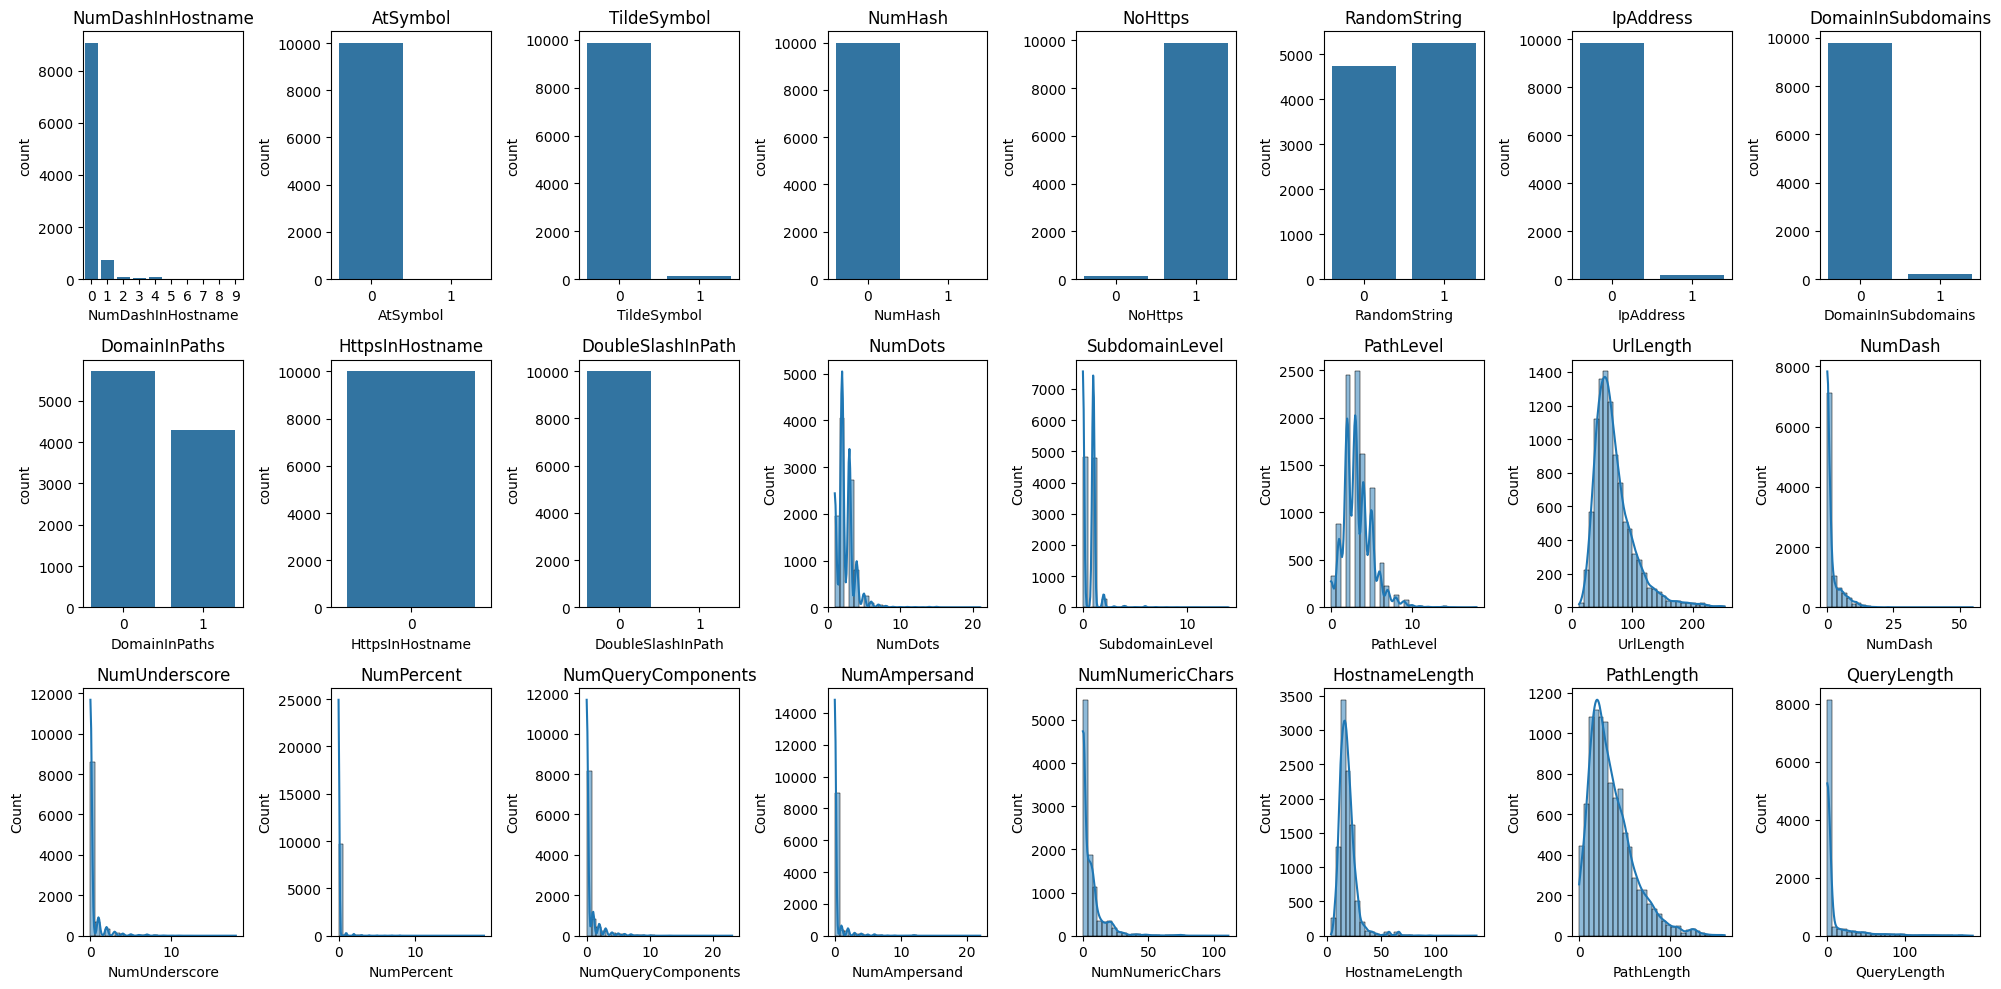

In [10]:
df3=df.drop(columns=['CLASS_LABEL'])
discretas = [col for col in df3.columns if df3[col].nunique() <= 10]
continuas = [col for col in df3.columns if df3[col].nunique() > 10]
plt.figure(figsize=(20, 10)) 

# Barras para variables discretas
for i, col in enumerate(discretas, 1):
    plt.subplot(3,8, i)
    sns.countplot(x=col, data=df3)  
    plt.title(f'{col}') 

# Histplot para variables continuas
for j, col in enumerate(continuas, len(discretas) + 1):
    plt.subplot(3,8, j)
    sns.histplot(df3[col], kde=True, bins=30)  
    plt.title(f'{col}')  

plt.tight_layout()  
plt.show()

Lo propio con la variable mas importante, el TARGET que define si el registro es o no un enlace peligroso.

/var/folders/3z/73lxqgp11kb61sfk787_46800000gn/T/ipykernel_66145/1067439746.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


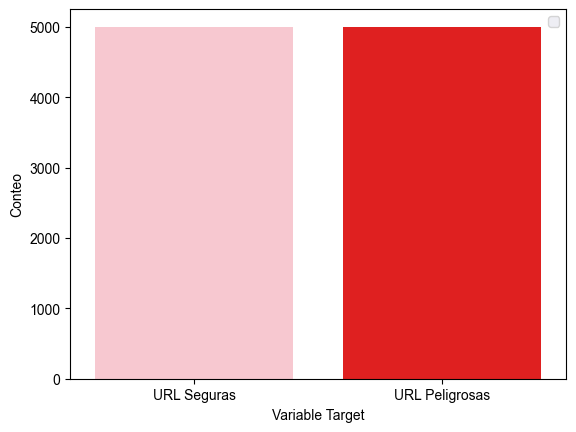

In [11]:
sns.countplot(x='CLASS_LABEL', data=df,hue='CLASS_LABEL',palette=['pink','red'],legend=False) 
plt.ylabel('Conteo')
sns.set_style('darkgrid')
plt.xlabel('Variable Target')
plt.legend()
plt.xticks([0, 1], ['URL Seguras', 'URL Peligrosas']);


In [12]:
df['CLASS_LABEL'].value_counts()

CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64

Que la variable target esté así de equilibrada es otra señal de que el CSV estaba perfectamente estructurado para ML.

Atendiendo al número de valores únicos que tiene cada columna, no merece la pena analizar los outliers de todas, sino unicamente de las que tienen, por ejemplo, mas de 10 valores diferentes. Eso trato de hacer en la siguiente celda.

In [13]:
df.nunique()[df.nunique()>=10].index

Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore', 'NumPercent',
       'NumQueryComponents', 'NumAmpersand', 'NumNumericChars',
       'HostnameLength', 'PathLength', 'QueryLength'],
      dtype='object')

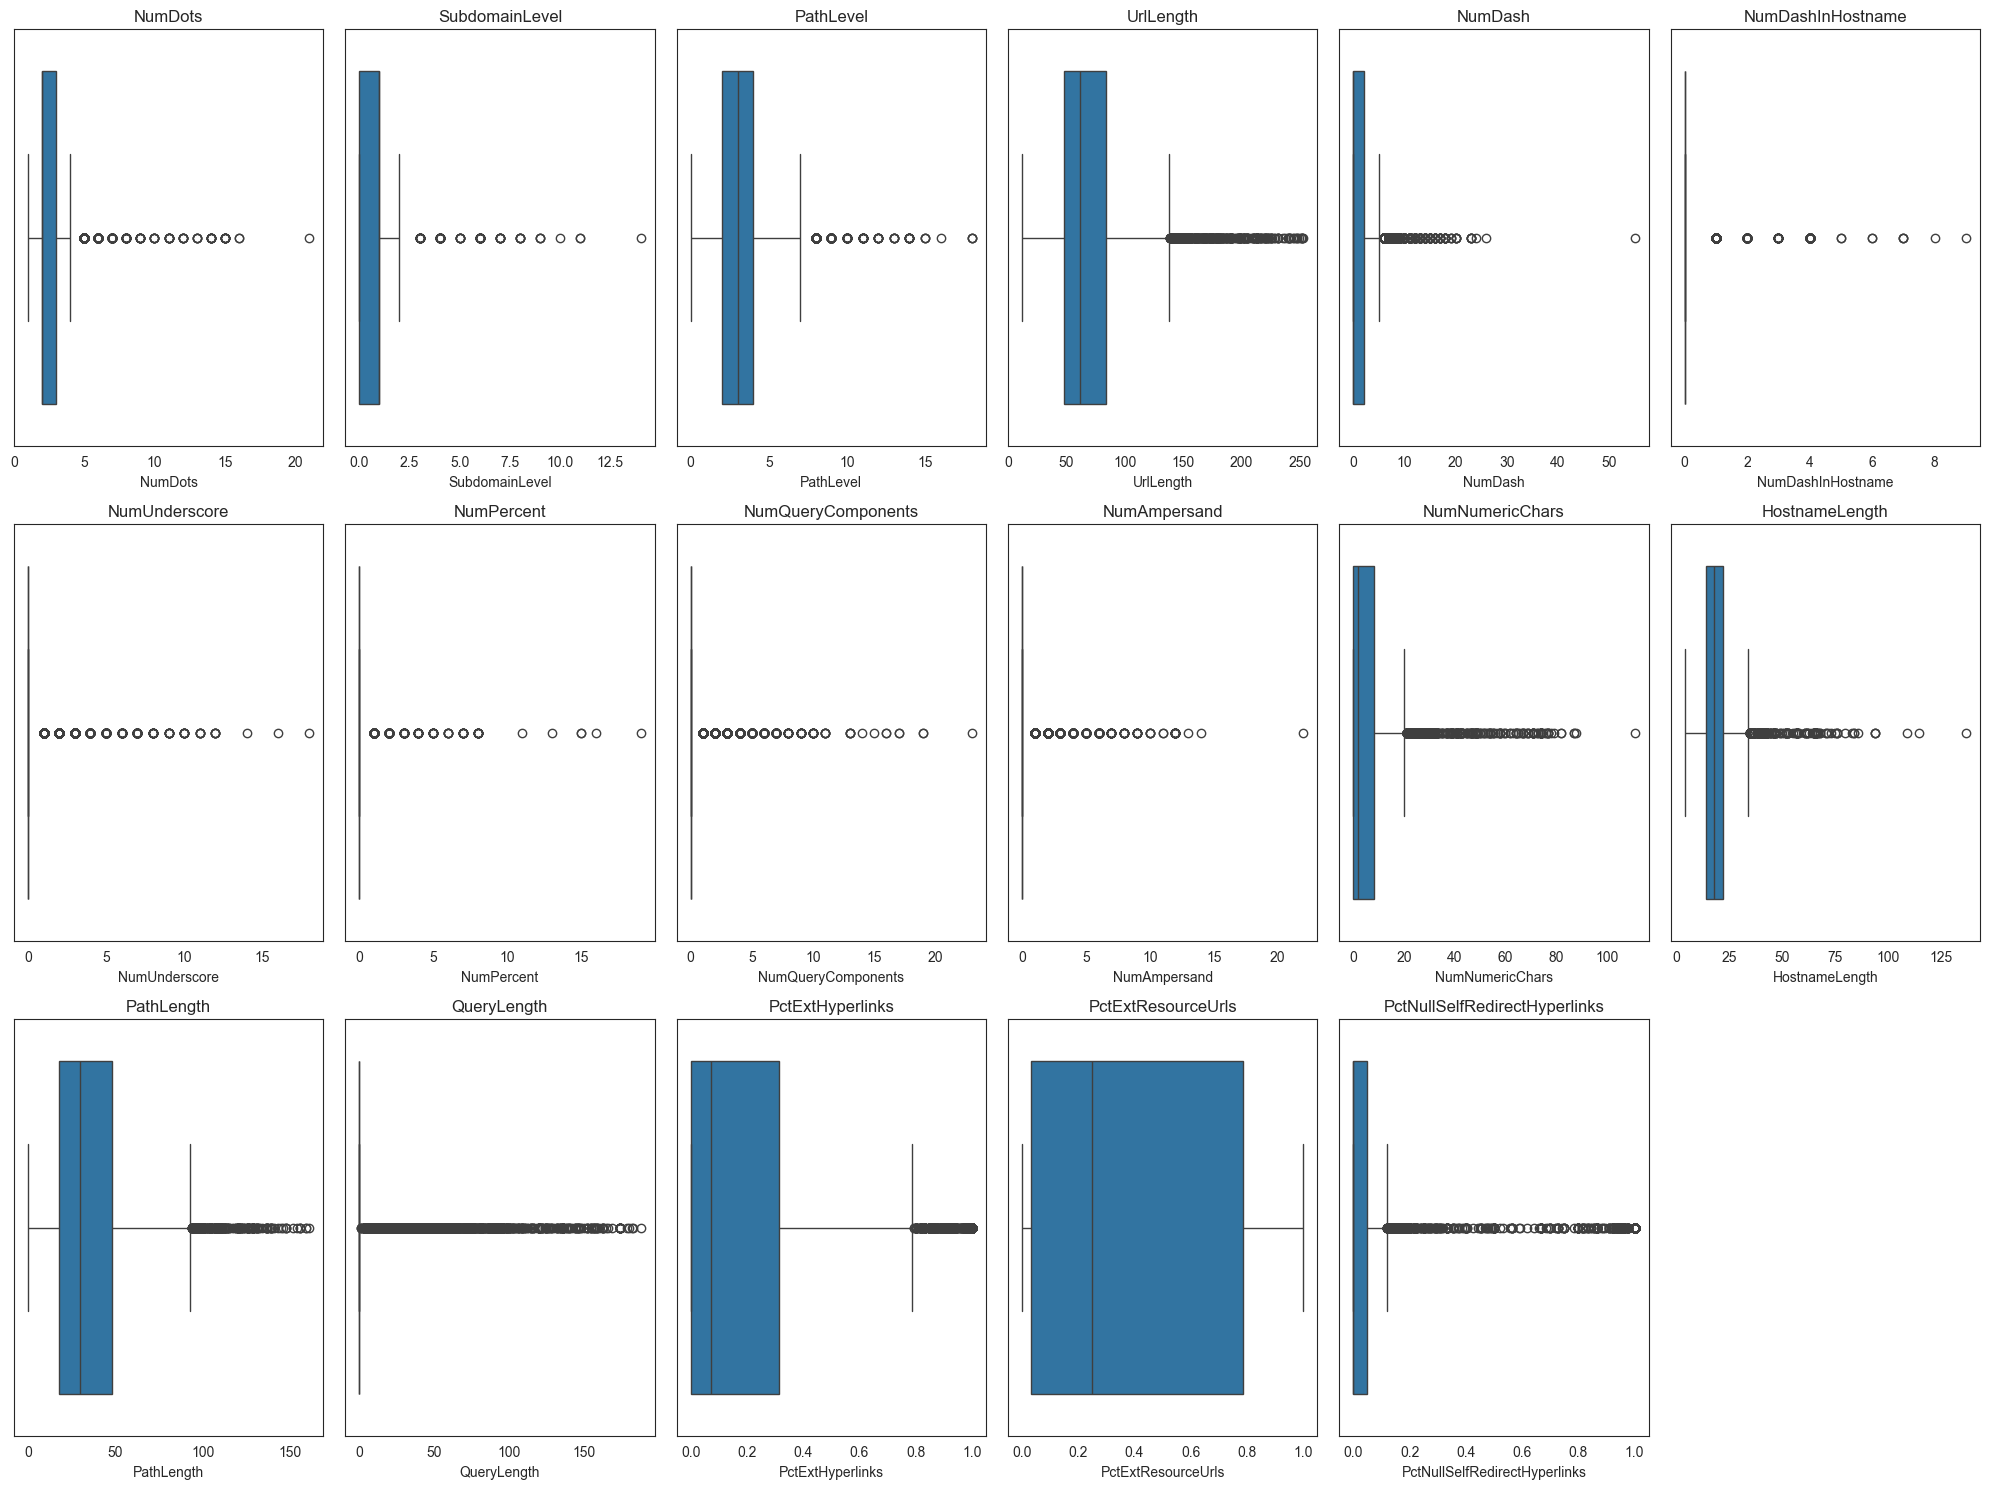

In [14]:
colboxplot= ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore', 'NumPercent',
       'NumQueryComponents', 'NumAmpersand', 'NumNumericChars',
       'HostnameLength', 'PathLength', 'QueryLength', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'PctNullSelfRedirectHyperlinks']

plt.figure(figsize=(20, 15))
sns.set_style('white')
for i, col in enumerate(colboxplot, 1):
    plt.subplot(3,6,i)
    sns.boxplot(x=df2[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Como esperaba, ningúna variable con valores anómalos o mal distribuidos.

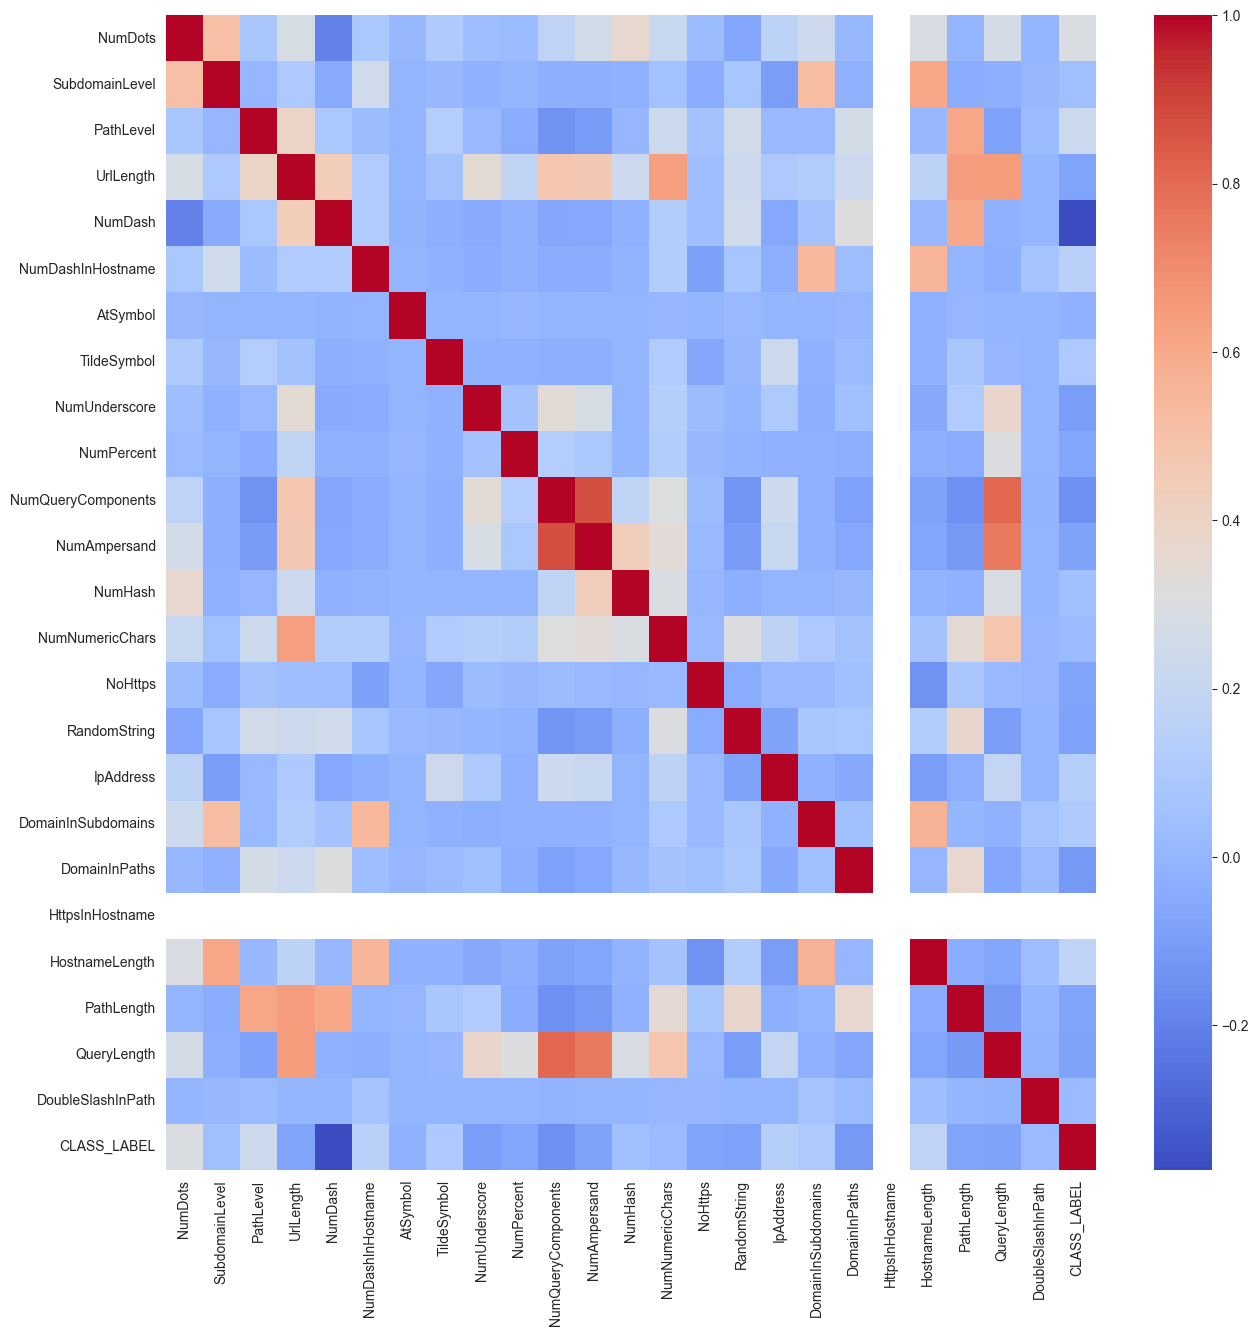

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap='coolwarm')
plt.show()

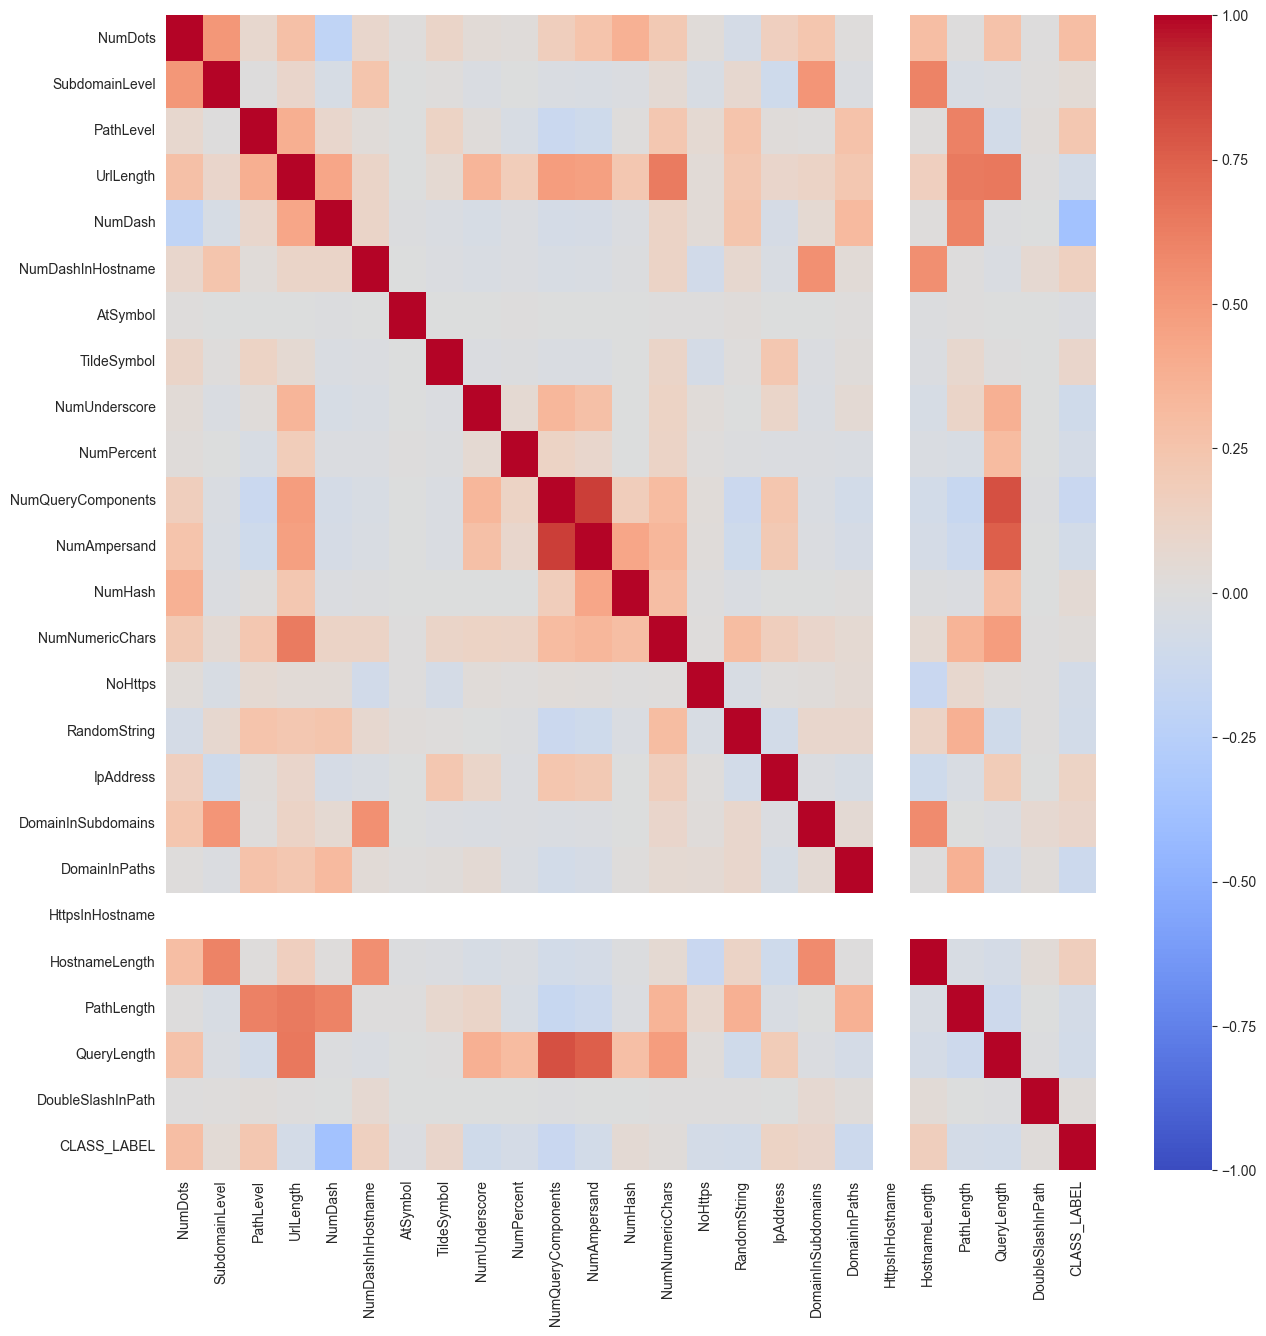

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap='coolwarm',vmin=(-1))
plt.show()

In [17]:
pd.set_option('display.max_columns', None)
df.corr()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,CLASS_LABEL
NumDots,1.000000,0.507992,0.079202,0.277380,-0.198769,0.093034,0.011425,0.109508,0.038068,0.022616,0.169283,0.255404,0.371642,0.211384,0.024590,-0.064631,0.158447,0.238473,0.009897,NaN,0.289482,0.000579,0.263039,0.002462,0.294111
SubdomainLevel,0.507992,1.000000,0.007277,0.098579,-0.050018,0.246368,-0.005845,0.009518,-0.023593,-0.006003,-0.029706,-0.031766,-0.018054,0.051744,-0.044628,0.076544,-0.103343,0.522014,-0.019847,NaN,0.605218,-0.039307,-0.026179,0.012070,0.043132
PathLevel,0.079202,0.007277,1.000000,0.390456,0.090503,0.027626,-0.005891,0.127291,0.015719,-0.043529,-0.140303,-0.104935,0.007947,0.233024,0.058466,0.250091,0.017895,0.014693,0.261468,NaN,0.013025,0.612786,-0.085555,0.020221,0.229450
UrlLength,0.277380,0.098579,0.390456,1.000000,0.437313,0.111980,-0.003425,0.058233,0.350756,0.184947,0.476699,0.466038,0.227029,0.637872,0.036667,0.230698,0.094311,0.120201,0.227722,NaN,0.162770,0.643924,0.649204,0.000162,-0.074493
NumDash,-0.198769,-0.050018,0.090503,0.437313,1.000000,0.113200,-0.010139,-0.024395,-0.050195,-0.017938,-0.064746,-0.056693,-0.023398,0.121830,0.036594,0.248141,-0.056135,0.056684,0.315989,NaN,0.010045,0.605889,-0.013725,-0.001462,-0.372235
NumDashInHostname,0.093034,0.246368,0.027626,0.111980,0.113200,1.000000,-0.004409,-0.018043,-0.035170,-0.021648,-0.042379,-0.036415,-0.008395,0.120447,-0.089577,0.073574,-0.033672,0.542477,0.038602,NaN,0.550247,0.000450,-0.029753,0.065692,0.150444
AtSymbol,0.011425,-0.005845,-0.005891,-0.003425,-0.010139,-0.004409,1.000000,-0.001996,-0.005023,0.007226,-0.005908,-0.004298,-0.000832,0.004545,0.001844,0.016471,-0.002292,-0.002610,0.008322,NaN,-0.013143,0.005943,-0.006132,-0.000520,-0.017323
TildeSymbol,0.109508,0.009518,0.127291,0.058233,-0.024395,-0.018043,-0.001996,1.000000,-0.022361,-0.013665,-0.024903,-0.026223,-0.005532,0.111735,-0.062954,0.009156,0.228278,-0.017360,0.019217,NaN,-0.021237,0.082378,0.003963,-0.003458,0.095864
NumUnderscore,0.038068,-0.023593,0.015719,0.350756,-0.050195,-0.035170,-0.005023,-0.022361,1.000000,0.061638,0.343520,0.279688,-0.002685,0.131965,0.027451,-0.001518,0.101720,-0.029686,0.049452,NaN,-0.053946,0.113097,0.380857,-0.005711,-0.098869
NumPercent,0.022616,-0.006003,-0.043529,0.184947,-0.017938,-0.021648,0.007226,-0.013665,0.061638,1.000000,0.129980,0.089819,-0.002340,0.121789,0.012623,-0.009526,-0.015691,-0.016781,-0.030047,NaN,-0.026739,-0.044664,0.305399,-0.003560,-0.068465


In [18]:
df.corr()["CLASS_LABEL"].sort_values(ascending=False,key=abs)

CLASS_LABEL           1.000000
NumDash              -0.372235
NumDots               0.294111
PathLevel             0.229450
HostnameLength        0.169157
NumDashInHostname     0.150444
NumQueryComponents   -0.147391
IpAddress             0.132291
DomainInPaths        -0.118201
DomainInSubdomains    0.100452
NumUnderscore        -0.098869
TildeSymbol           0.095864
RandomString         -0.085308
NumAmpersand         -0.081446
QueryLength          -0.080525
PathLength           -0.076125
UrlLength            -0.074493
NoHttps              -0.072219
NumPercent           -0.068465
NumHash               0.048014
SubdomainLevel        0.043132
DoubleSlashInPath     0.023344
NumNumericChars       0.019122
AtSymbol             -0.017323
HttpsInHostname            NaN
Name: CLASS_LABEL, dtype: float64

---

## 3.1 FEATURE ENGINEERING

Se tratan los escasos outliers, se crean nuevas variables y se transforman las existentes para mejorar el rendimiento del modelo. El csv está limpio y preparado para un Modelo, pero para tratar de obtener variables mas útiles e interesantes para el desarrollo del modelo, resulta adecuado probar algunas manipulaciones y combinaciones de las variables existentes.

In [19]:
#Borramos la variable que solo tiene un valor
df.drop(columns=['HttpsInHostname'],inplace=True)
df.head()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,CLASS_LABEL
id,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,5,72,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,21,44,0,0,1
2,3,1,3,144,0,0,0,0,2,0,2,1,0,41,1,0,0,0,0,17,16,103,0,1
3,3,1,2,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,27,24,0,0,1
4,3,1,6,79,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,22,50,0,0,1
5,3,0,4,46,0,0,0,0,0,0,0,0,0,2,1,1,0,0,1,10,29,0,0,1


In [20]:
# Sumar los caracteres especiales y otra con un ratio de ellos respecto a la longitud del url
df['SpecialChars'] = df['NumDots'] + df['NumDash'] + df['NumUnderscore']
df['SpecialCharRatio'] = df['SpecialChars'] / df['UrlLength']
print(df[['SpecialChars','SpecialCharRatio']].nunique())
print("---\n",df[['SpecialChars','SpecialCharRatio']].value_counts())

SpecialChars         27
SpecialCharRatio    903
dtype: int64
---
 SpecialChars  SpecialCharRatio
3             0.063830            85
2             0.046512            83
              0.041667            73
3             0.060000            73
              0.058824            71
                                  ..
1             0.008333             1
              0.007752             1
              0.007576             1
              0.007246             1
              0.006024             1
Name: count, Length: 1407, dtype: int64


In [21]:
df['PctNumerics'] = df['NumNumericChars'] / df['UrlLength']
# Un ratio de caracteres numéricos en la URL respecto a la longitud
df['PctNumerics'].nunique()

1495

In [22]:
#Ratio de caracteres especiales en el nombre del host.
# Esta he tenido que buscar como hacerla bien, y claro cada subdominio se separa por puntos por lo que el numero de niveles es el numero de puntos en el Host
df['SCHostRatio'] = (df['NumDashInHostname'] + df['SubdomainLevel']) / df['HostnameLength'].replace(0,1) #El replace por si acaso hay algun HostnameLength de 0
df['SCHostRatio'].value_counts()

SCHostRatio
0.000000    4487
0.055556     387
0.058824     383
0.052632     371
0.050000     351
            ... 
0.102564       1
0.075000       1
0.113208       1
0.073171       1
0.078947       1
Name: count, Length: 122, dtype: int64

In [23]:
# Ratio de la longitud del dominio respecto de todo el enlace
df['HostnameRatio'] = df['HostnameLength'] / df['UrlLength']
df[['HostnameLength','UrlLength','HostnameRatio']]

,HostnameLength,UrlLength,HostnameRatio
id,,,
1,21,72,0.291667
2,17,144,0.118056
3,27,58,0.465517
4,22,79,0.278481
5,10,46,0.217391
...,...,...,...
9996,15,50,0.300000
9997,19,59,0.322034
9998,16,57,0.280702


In [24]:
#Suma de los principales elementos sospechosos binarios (pese a que tambien son útiles, no tendria sentido sumar aqui variables de 'length' o que tengan valores no binarios)
df['SuspiciousElements'] = df['IpAddress'] + df['NoHttps'] + df['DomainInPaths'] + df['DomainInSubdomains'] + df['DoubleSlashInPath']
df['SuspiciousElements'].value_counts()

SuspiciousElements
1    5420
2    4313
3     174
0      90
4       3
Name: count, dtype: int64

In [25]:
#Longitud promedio de la ruta según el nivel 
df['AvgPathLength'] = df['PathLength'] / df['PathLevel'].replace(0, 1)
#De nuevo, el replace lo he tenido que añadir porque hay alguna que es 0 y me crea infinitos que no puedo analizar en el modelo
df[['PathLength','PathLevel','AvgPathLength']].head()

,PathLength,PathLevel,AvgPathLength
id,,,
1,44,5,8.800000
2,16,3,5.333333
3,24,2,12.000000
4,50,6,8.333333
5,29,4,7.250000


In [26]:
#Ratio de parametros 
df['QueryRatio'] = df['NumQueryComponents'] / df['QueryLength'].replace(0, 1)
df[['NumQueryComponents','QueryLength','QueryRatio']].tail()

,NumQueryComponents,QueryLength,QueryRatio
id,,,
9996,2,17,0.117647
9997,0,0,0.000000
9998,0,0,0.000000
9999,1,13,0.076923
10000,0,0,0.000000


In [27]:
#Logaritmizar las tres variables de las que hay valores extensamente distribuidos (desde menos de 10 a mas de 100)
df['log_UrlLength'] = np.log1p(df['UrlLength'])
df['log_PathLength']=np.log1p(df['PathLength'])
df['log_Querylength']=np.log1p(df['QueryLength'])
df[['UrlLength','log_UrlLength','PathLength','log_PathLength','QueryLength','log_Querylength']]

,UrlLength,log_UrlLength,PathLength,log_PathLength,QueryLength,log_Querylength
id,,,,,,
1,72,4.290459,44,3.806662,0,0.000000
2,144,4.976734,16,2.833213,103,4.644391
3,58,4.077537,24,3.218876,0,0.000000
4,79,4.382027,50,3.931826,0,0.000000
5,46,3.850148,29,3.401197,0,0.000000
...,...,...,...,...,...,...
9996,50,3.931826,10,2.397895,17,2.890372
9997,59,4.094345,33,3.526361,0,0.000000
9998,57,4.060443,34,3.555348,0,0.000000


#### GUARDAR DATOS PROCESADOS

In [28]:
df.to_csv("../data/Processed/dataset_processed.csv")

## 3.2 EDA POST ENGINEERING
Tras las manipulaciones realizadas, cabe analizar rapidamente la distribucion de las nuevas variables, y sobre todo su correlación, especialmente con la variable objetivo y con las demás variables principales, para ver si merece la pena incluirlas en futuros modelos. 

In [29]:
df.columns

Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HostnameLength', 'PathLength',
       'QueryLength', 'DoubleSlashInPath', 'CLASS_LABEL', 'SpecialChars',
       'SpecialCharRatio', 'PctNumerics', 'SCHostRatio', 'HostnameRatio',
       'SuspiciousElements', 'AvgPathLength', 'QueryRatio', 'log_UrlLength',
       'log_PathLength', 'log_Querylength'],
      dtype='object')

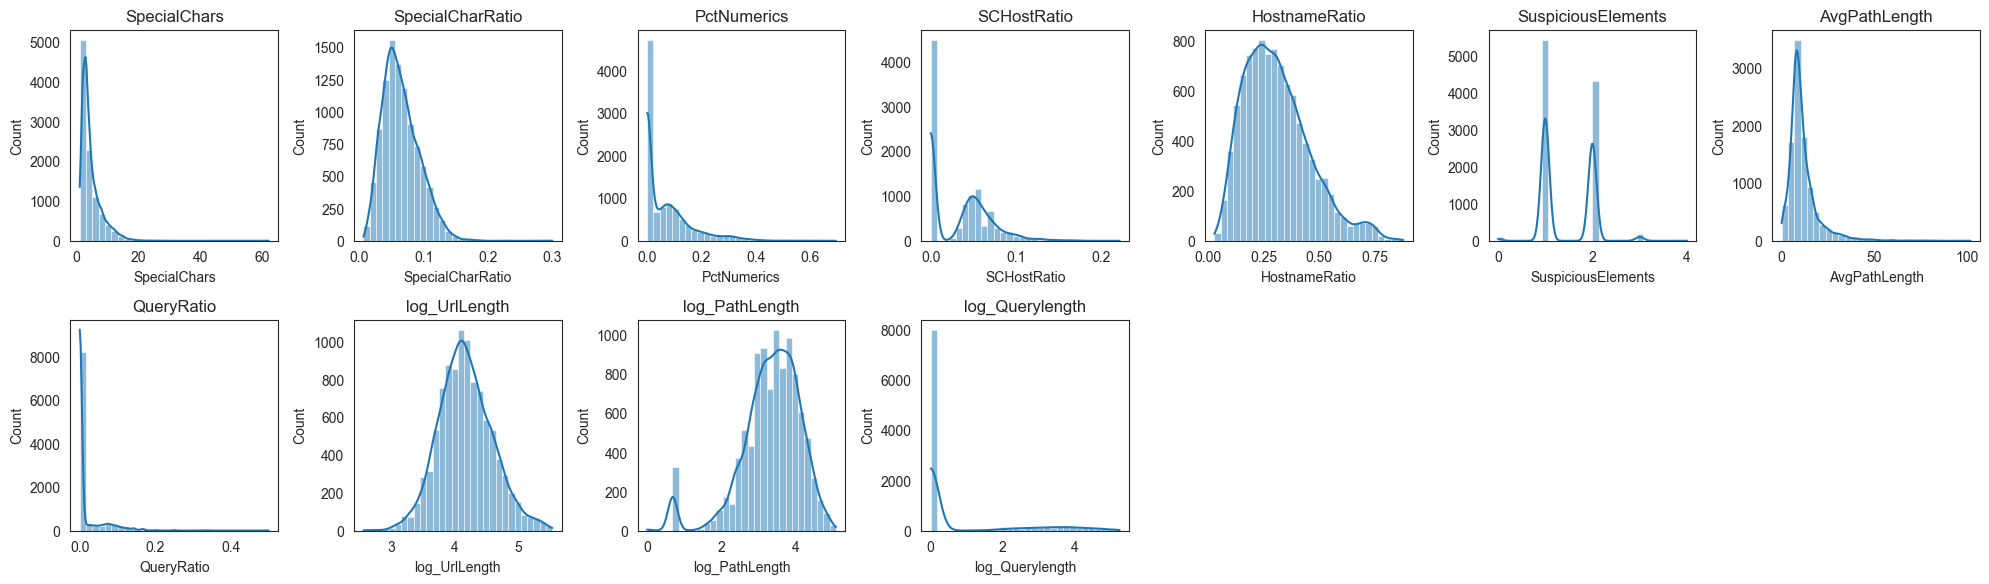

In [30]:
nuevascolumnas=['SpecialChars', 'SpecialCharRatio', 'PctNumerics',
       'SCHostRatio','HostnameRatio', 'SuspiciousElements',
       'AvgPathLength', 'QueryRatio', 'log_UrlLength', 'log_PathLength',
       'log_Querylength']
plt.figure(figsize=(20, 20))  # Ajusta el tamaño según la cantidad de variables
for i, col in enumerate(nuevascolumnas, 1):
    plt.subplot(7,7, i) 
    sns.histplot(df[col], kde=True, bins=30)  
    plt.title(col)  # Título con el nombre de la variable

plt.tight_layout()  # Ajusta los gráficos para que no se sobrepongan
plt.show()

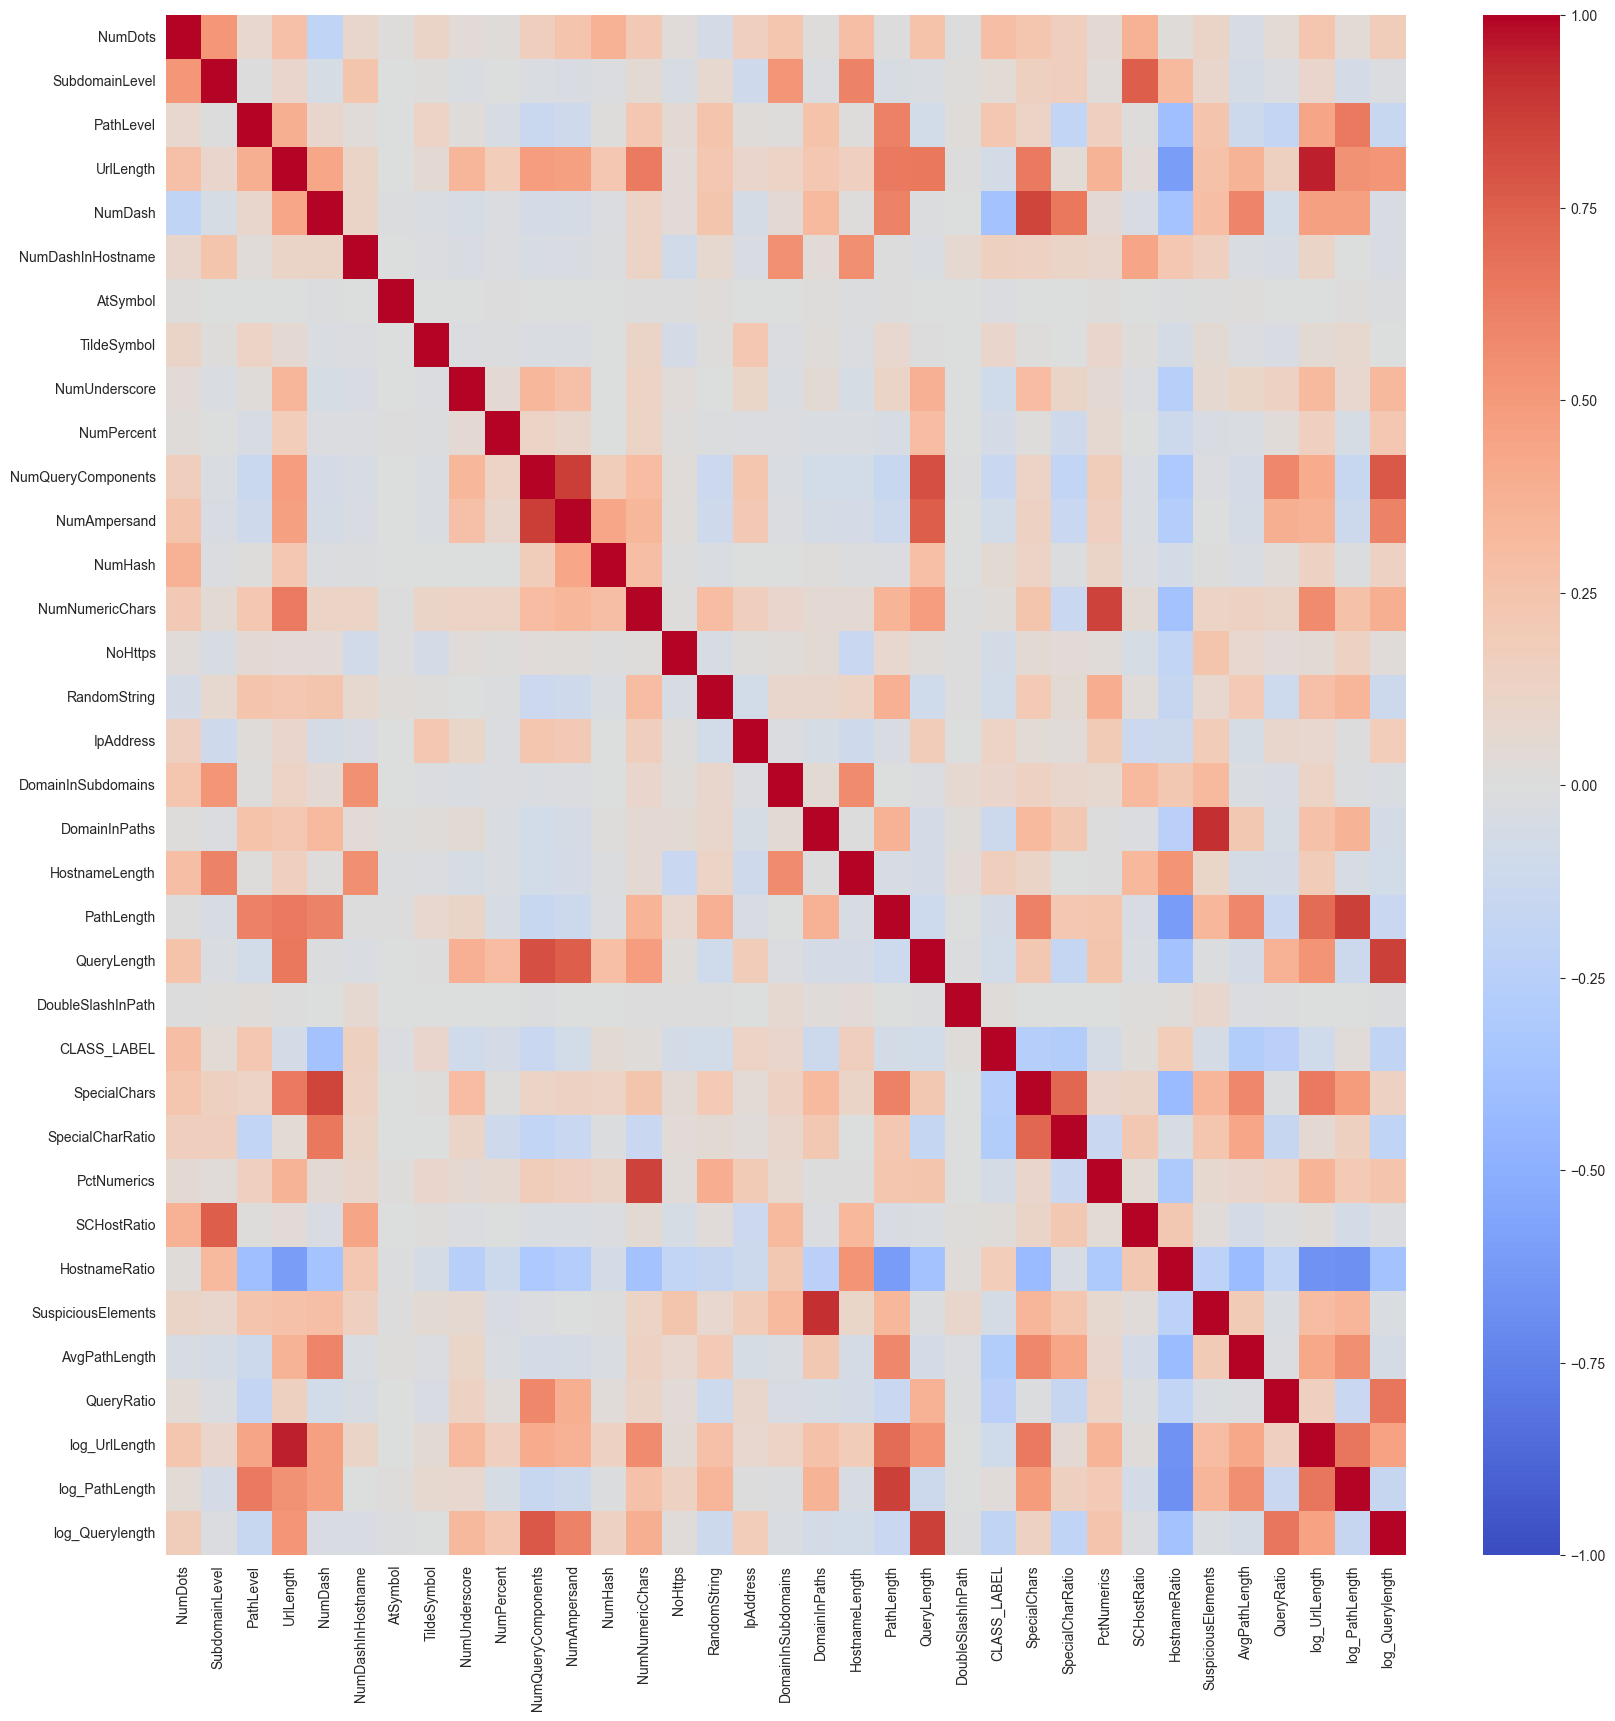

In [31]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),cmap='coolwarm',vmin=(-1))
plt.show()

In [32]:
pd.set_option('display.max_columns', None)
df.corr()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,CLASS_LABEL,SpecialChars,SpecialCharRatio,PctNumerics,SCHostRatio,HostnameRatio,SuspiciousElements,AvgPathLength,QueryRatio,log_UrlLength,log_PathLength,log_Querylength
NumDots,1.000000,0.507992,0.079202,0.277380,-0.198769,0.093034,0.011425,0.109508,0.038068,0.022616,0.169283,0.255404,0.371642,0.211384,0.024590,-0.064631,0.158447,0.238473,0.009897,0.289482,0.000579,0.263039,0.002462,0.294111,0.234767,0.165992,0.060444,0.373405,0.019091,0.115019,-0.043576,0.043950,0.239617,0.043090,0.176404
SubdomainLevel,0.507992,1.000000,0.007277,0.098579,-0.050018,0.246368,-0.005845,0.009518,-0.023593,-0.006003,-0.029706,-0.031766,-0.018054,0.051744,-0.044628,0.076544,-0.103343,0.522014,-0.019847,0.605218,-0.039307,-0.026179,0.012070,0.043132,0.152848,0.169440,0.030520,0.753912,0.319879,0.089617,-0.060938,-0.017132,0.096664,-0.069466,-0.019104
PathLevel,0.079202,0.007277,1.000000,0.390456,0.090503,0.027626,-0.005891,0.127291,0.015719,-0.043529,-0.140303,-0.104935,0.007947,0.233024,0.058466,0.250091,0.017895,0.014693,0.261468,0.013025,0.612786,-0.085555,0.020221,0.229450,0.123285,-0.180236,0.157872,0.011875,-0.397292,0.255596,-0.123087,-0.176694,0.442814,0.642680,-0.150950
UrlLength,0.277380,0.098579,0.390456,1.000000,0.437313,0.111980,-0.003425,0.058233,0.350756,0.184947,0.476699,0.466038,0.227029,0.637872,0.036667,0.230698,0.094311,0.120201,0.227722,0.162770,0.643924,0.649204,0.000162,-0.074493,0.645734,0.042350,0.363578,0.034117,-0.603032,0.266287,0.360404,0.156043,0.953095,0.538175,0.515902
NumDash,-0.198769,-0.050018,0.090503,0.437313,1.000000,0.113200,-0.010139,-0.024395,-0.050195,-0.017938,-0.064746,-0.056693,-0.023398,0.121830,0.036594,0.248141,-0.056135,0.056684,0.315989,0.010045,0.605889,-0.013725,-0.001462,-0.372235,0.846372,0.655251,0.056430,-0.031870,-0.365091,0.293017,0.596300,-0.083670,0.465136,0.465573,-0.038745
NumDashInHostname,0.093034,0.246368,0.027626,0.111980,0.113200,1.000000,-0.004409,-0.018043,-0.035170,-0.021648,-0.042379,-0.036415,-0.008395,0.120447,-0.089577,0.073574,-0.033672,0.542477,0.038602,0.550247,0.000450,-0.029753,0.065692,0.150444,0.133142,0.112350,0.086219,0.443813,0.233623,0.158448,-0.027706,-0.043833,0.113824,-0.002871,-0.037639
AtSymbol,0.011425,-0.005845,-0.005891,-0.003425,-0.010139,-0.004409,1.000000,-0.001996,-0.005023,0.007226,-0.005908,-0.004298,-0.000832,0.004545,0.001844,0.016471,-0.002292,-0.002610,0.008322,-0.013143,0.005943,-0.006132,-0.000520,-0.017323,-0.006602,-0.007494,0.011063,-0.005667,-0.012201,0.006569,0.012199,-0.006827,-0.000581,0.009404,-0.008283
TildeSymbol,0.109508,0.009518,0.127291,0.058233,-0.024395,-0.018043,-0.001996,1.000000,-0.022361,-0.013665,-0.024903,-0.026223,-0.005532,0.111735,-0.062954,0.009156,0.228278,-0.017360,0.019217,-0.021237,0.082378,0.003963,-0.003458,0.095864,0.014231,-0.006976,0.099325,0.014055,-0.054737,0.054341,-0.020493,-0.035939,0.050858,0.070623,-0.007112
NumUnderscore,0.038068,-0.023593,0.015719,0.350756,-0.050195,-0.035170,-0.005023,-0.022361,1.000000,0.061638,0.343520,0.279688,-0.002685,0.131965,0.027451,-0.001518,0.101720,-0.029686,0.049452,-0.053946,0.113097,0.380857,-0.005711,-0.098869,0.307211,0.110885,0.056002,-0.021168,-0.250183,0.065498,0.103170,0.141000,0.317144,0.084805,0.326633
NumPercent,0.022616,-0.006003,-0.043529,0.184947,-0.017938,-0.021648,0.007226,-0.013665,0.061638,1.000000,0.129980,0.089819,-0.002340,0.121789,0.012623,-0.009526,-0.015691,-0.016781,-0.030047,-0.026739,-0.044664,0.305399,-0.003560,-0.068465,0.013215,-0.102889,0.069650,-0.007459,-0.119460,-0.033003,-0.026677,0.028260,0.160281,-0.054679,0.227155


In [33]:
df.corr()["CLASS_LABEL"].sort_values(ascending=False,key=abs)

CLASS_LABEL           1.000000
NumDash              -0.372235
NumDots               0.294111
AvgPathLength        -0.276552
SpecialCharRatio     -0.273858
SpecialChars         -0.264729
QueryRatio           -0.239121
PathLevel             0.229450
log_Querylength      -0.191751
HostnameRatio         0.187061
HostnameLength        0.169157
NumDashInHostname     0.150444
NumQueryComponents   -0.147391
IpAddress             0.132291
DomainInPaths        -0.118201
DomainInSubdomains    0.100452
NumUnderscore        -0.098869
TildeSymbol           0.095864
log_UrlLength        -0.094081
RandomString         -0.085308
NumAmpersand         -0.081446
QueryLength          -0.080525
PathLength           -0.076125
UrlLength            -0.074493
NoHttps              -0.072219
NumPercent           -0.068465
SuspiciousElements   -0.060694
PctNumerics          -0.060444
NumHash               0.048014
SubdomainLevel        0.043132
log_PathLength        0.025494
DoubleSlashInPath     0.023344
SCHostRa

---

# 4. ELABORACIÓN Y EVALUACIÓN DE MODELOS

En este apartado auto-explicativo, se desarrolla la selección de variables en base a las correlaciones y análisis realizados previamente, y la elaboración de los diferentes modelos. Finalmente, en base a la evaluación de los mismos, se seleccionan cuales van a ser los All-Star (los 6 elegidos para cumplir las exigencias del proyecto) y el MVP (el modelo que va a utilizar Streamlit para la ejecución práctica del proyecto en Local).

Aqui cabe comentar que antes de la realización del Feature Engineering ya se habián desarrollado dos modelos –uno con las mejores variables de entre todas, y otro con las mejores pero solo de las relativas a la estructura del URL- y una búsqueda de los mejores modelos y parámetros; que se va a mantener pues no es de agrado borrar tanto trabajo. 

## 4.1 MODELADOS PRE-ENGINEERING

Como comenté anteriormente, se realiza un modelo con las mejores variables según SelectFrom antes y despues de descartar las que tienen un VIF demasiado alto.   
### MODELT1 - MODELO CON LAS MEJORES VARIABLES DEL DATASET ORIGINAL

Por último, antes de hacer el F-E, quería ver que variables eran las mejores para hacer el primer modelo de prueba, para lo que elaboré un SelectFromModel de SkLearn.   
Por pura curiosidad, voy a testear la fiabilidad y utilidad de VIF, realizando un modelo con las mejores directamente, y el mismo modelo con las mejores pero descartando las que tengan un VIF superior a 10

In [34]:
A=df2.drop(columns=['CLASS_LABEL'])
B=df2['CLASS_LABEL']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(A,B)

# Aplicar SelectFromModel con una umbral automático basado en importancia de características
selector = SelectFromModel(clf, prefit=True)
selected_features = A.columns[selector.get_support()]

print("Variables seleccionadas:", selected_features)


Variables seleccionadas: Index(['NumDots', 'PathLevel', 'NumDash', 'NumNumericChars',
       'PctExtHyperlinks', 'PctExtResourceUrls', 'InsecureForms',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'SubmitInfoToEmail', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT'],
      dtype='object')


In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

A=df2.drop(columns=['CLASS_LABEL'])
def calculate_vif(A):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = A.columns
    vif_data["VIF"] = [variance_inflation_factor(A.values, i) for i in range(A.shape[1])]
    return vif_data

# Llamar a la función
vif_df = calculate_vif(A)
vif_df.sort_values(by='VIF').head(10)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Variable,VIF
6,AtSymbol,1.004804
23,DoubleSlashInPath,1.012711
35,FakeLinkInStatusBar,1.014919
37,PopUpWindow,1.026241
41,ImagesOnlyInForm,1.065281
7,TildeSymbol,1.134490
40,MissingTitle,1.172329
9,NumPercent,1.232057
38,SubmitInfoToEmail,1.302919
25,EmbeddedBrandName,1.326746


In [36]:
Xt1=df2[['NumDots', 'PathLevel', 'NumDash', 'NumNumericChars',
       'PctExtHyperlinks', 'PctExtResourceUrls', 'InsecureForms',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'SubmitInfoToEmail', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT']]
y=df2['CLASS_LABEL']

In [37]:
X1_train, X1_test, y1_train, y1_test = train_test_split(Xt1, y, test_size=0.2, random_state=42)

In [38]:
## GUARDAR LOS DATOS PARA ESTE MODELO (SON DIFERENTES QUE PARA LOS DEMÁS)
X1_train.to_csv("../data/MODELT1/X1_train.csv")
X1_test.to_csv("../data/MODELT1/X1_test.csv")
y1_train.to_csv("../data/MODELT1/y1_train.csv")
y1_test.to_csv("../data/MODELT1/y1_test.csv")

In [39]:
scaler=StandardScaler()
X1_trains=scaler.fit_transform(X1_train)
X1_tests=scaler.fit_transform(X1_test)

# Inicializar el modelo
modelt1 = LogisticRegression(solver= 'liblinear', penalty= 'l1', C= 1)

# Entrenar el modelo
modelt1.fit(X1_trains, y1_train)

# Hacer predicciones
y1_predt1 = modelt1.predict(X1_tests)

In [115]:
accuracyt1 = accuracy_score(y1_test, y1_predt1)
precisiont1 = precision_score(y1_test, y1_predt1)
recallt1 = recall_score(y1_test, y1_predt1)
f1t1 = f1_score(y1_test, y1_predt1)

print(f'Accuracy: {accuracyt1 * 100:.2f}%')
print(f'Precision: {precisiont1 * 100:.2f}%')
print(f'Recall: {recallt1 * 100:.2f}%')
print(f'F1 Score: {f1t1 * 100:.2f}%')

cmt1 = confusion_matrix(y1_test, y1_predt1)
print(f'Confusion matrix:\n{cmt1}')
print(classification_report(y1_test, y1_predt1))

Accuracy: 91.75%
Precision: 90.84%
Recall: 93.08%
F1 Score: 91.95%
Confusion matrix:
[[893  95]
 [ 70 942]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       988
           1       0.91      0.93      0.92      1012

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



Aunque utiliza unas variables que no voy a utilizar en mis modelos, el alto acierto de este modelo justifica que lo guarde como uno de los elaborados. (Calma, este no cuenta, haré 6 más).

### MODELO CON LAS MEJORES VARIABLES DESCARTANDO LAS DE VIF ALTO 

In [41]:
Xt2=df2[['NumDots', 'PathLevel', 'NumDash', 'NumQueryComponents',
       'NumNumericChars', 'NumSensitiveWords', 'ExtFavicon', 'InsecureForms',
       'FrequentDomainNameMismatch', 'SubmitInfoToEmail',
       'PctExtResourceUrlsRT', 'ExtMetaScriptLinkRT']]

X_train, X_test, y_train, y_test = train_test_split(Xt2, y, test_size=0.2, random_state=42)

scaler=StandardScaler()
X_trains=scaler.fit_transform(X_train)
X_tests=scaler.fit_transform(X_test)

# Inicializar el modelo
model = LogisticRegression(solver= 'liblinear', penalty= 'l1', C= 1)

# Entrenar el modelo
model.fit(X_trains, y_train)

# Hacer predicciones
y_predt2 = model.predict(X_tests)

In [42]:
accuracyt2 = accuracy_score(y_test, y_predt2)
print(f'Accuracy: {accuracyt2 * 100:.2f}%')

# Matriz de confusión
cmt2 = confusion_matrix(y_test, y_predt2)
print(f'Confusion Matrix:\n{cmt2}')

print(classification_report(y_test,y_predt2))

Accuracy: 91.20%
Confusion Matrix:
[[890  98]
 [ 78 934]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       988
           1       0.91      0.92      0.91      1012

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



## 4.2 MODELOS SUPERVISADOS

### BUSQUEDA DE VARIABLES ORIGINALES Y SPLIT

Atendiendo al SelectFromModel y el VIF que se realizan, los índices de correlación y la utilidad y posible aplicación en Streamlit, se elige un grupo de variables respecto del dataset original (esta es la selección previa al F-E).

In [43]:
df2.drop(columns=['NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT'],inplace=True)

In [44]:
#SELECT FROM MODEL PARA ELEGIR LAS VARIABLES
A=df2.drop(columns=['CLASS_LABEL'])
B=df['CLASS_LABEL']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(A,B)

# Aplicar SelectFromModel con una umbral automático basado en importancia de características
selector = SelectFromModel(clf, prefit=True)
selected_features = A.columns[selector.get_support()]

print("Variables seleccionadas:", selected_features)


Variables seleccionadas: Index(['NumDots', 'PathLevel', 'UrlLength', 'NumDash', 'NumNumericChars',
       'HostnameLength', 'PathLength'],
      dtype='object')


In [45]:
Xr=df[['NumDash','NumDots','NumDashInHostname','UrlLength','NumQueryComponents','IpAddress','DomainInSubdomains', 'DomainInPaths','HostnameLength', 'PathLevel']]
y=y


In [46]:
X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_trains=scaler.fit_transform(X_train)
X_tests=scaler.fit_transform(X_test)

#### GUARDADO DE TRAIN Y TEST DEFINITIVO

In [47]:
X_train.to_csv("../data/Train/X_train.csv")
X_test.to_csv("../data/Test/X_test.csv")
y_train.to_csv("../data/Train/y_train.csv")
y_test.to_csv("../data/Test/y_test.csv")

## 1. **MODEL RF1** - RANDOM FOREST

Tras realizar un Pipeline como el que se incluye más adelante y contrastarlo con un GridSearch, di con un modelo de Random Forest y ciertos parametros que me dió un nivel de acierto considerable. Utilizando unicamente las variables con mejor correlación y utilidad, atendiendo a su colinealidad, los resultados de un VIF y un SelectFromModel, y a la facilidad de emplearlos en Streamlit. Aunque queda pendiente de ver si es el modelo definitivo, es el que originalmente tenía vinculado a Streamlit, por lo que voy a mantenerlo mientras ningún modelo supere sus resultados.

In [48]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("classifier", SVC())])

# Definir el espacio de búsqueda para cada modelo
logistic_params = {
    "classifier": [LogisticRegression(max_iter=1000, solver="liblinear"), 
                   LogisticRegression(max_iter=1000, solver="lbfgs")],
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.1, 1, 10] 
}

random_forest_params = {
    "scaler": [StandardScaler(), MinMaxScaler(), None],  
    "classifier": [RandomForestClassifier()],
    "classifier__n_estimators": [100, 200,300],
    "classifier__max_depth": [20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False]
}

decision_tree_params = {
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    "classifier": [DecisionTreeClassifier()],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 4]
}

knn_params = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "classifier": [KNeighborsClassifier()],
    "classifier__n_neighbors": [3, 7],
    "classifier__weights": ["uniform", "distance"]
}

svm_params = {
    "classifier": [SVC()],
    "classifier__C": [ 0.5, 5, 10],
    "classifier__kernel": ["linear", "rbf"],
    "classifier__gamma": ["scale", "auto"]
}
#El Pipeline-GridSearch ya ha sido ejecutado y se han aplicado sus resultados, por lo que he eliminado algunos parámetros a gridear para que no se demore tanto tiempo

In [49]:
# search_space = [logistic_params, random_forest_params, decision_tree_params, knn_params, svm_params]

# # GridSearchCV para encontrar el mejor modelo
# clf = GridSearchCV(
#     estimator=pipe,
#     param_grid=search_space,
#     cv=5,
#     verbose=False,
#     n_jobs=-1,
#     scoring="accuracy"
# )

# # Entrenar el modelo
# clf.fit(X_train, y_train)

# # Mostrar los resultados
# print(clf.best_estimator_)
# print("Mejor accuracy en validación:", clf.best_score_)
# print("Mejores parámetros:", clf.best_params_)

# # Evaluar en el test set
# y_pred = clf.best_estimator_.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy en test:", accuracy)


^ Esta comentada porque se demora mucho.    
El outcome es que el best_estimator es Random Forest con {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}, y una accuracy en validación y en test que ahora no recuerdo pero superaban el 80%  

In [50]:
rf1 = RandomForestClassifier(random_state=13)

param_grid = {
     "n_estimators": [50,100,200],  
     "max_depth": [20,30],  
     "min_samples_split": [2, 5, 10],  
     "min_samples_leaf": [1, 2, 4], 
     "bootstrap": [True, False]  
 }
# grid_search = GridSearchCV(estimator=rf1,param_grid=param_grid,cv=5,n_jobs=-1, verbose=False,  scoring="accuracy")

# grid_search.fit(X_train, y_train)

# print("Mejores hiperparametros:", grid_search.best_params_)

# best_rf = grid_search.best_estimator_

# prediccionrf = best_rf.predict(X_test)
# accuracy_score(y_test, prediccionrf)


Outcome de esta celda (está comentada porque se demora casi 5 minutos):

Mejores hiperparametros: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}   

0.853

In [129]:
modelorf=RandomForestClassifier(max_depth=20,
                            n_estimators=100,
                            min_samples_leaf=2,
                            bootstrap=True,
                            min_samples_split=10)

modelorf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [130]:
prediccionesrf=modelorf.predict(X_test)

In [131]:
prediccionesrf=modelorf.predict(X_test)
accuracyrf = accuracy_score(y_test, prediccionesrf)
precisionrf = precision_score(y_test, prediccionesrf)
recallrf = recall_score(y_test, prediccionesrf)
f1rf = f1_score(y_test, prediccionesrf)

# --- Imprimir métricas ---
print(f'Accuracy: {accuracyrf * 100:.2f}%')
print(f'Precision: {precisionrf * 100:.2f}%')
print(f'Recall: {recallrf * 100:.2f}%')
print(f'F1 Score: {f1rf * 100:.2f}%')

# Matriz de confusión
cmrf = confusion_matrix(y_test, prediccionesrf)
print(f'Confusion Matrix:\n{cmrf}')

print(classification_report(y_test,prediccionesrf))

Accuracy: 85.70%
Precision: 82.53%
Recall: 91.01%
F1 Score: 86.56%
Confusion Matrix:
[[793 195]
 [ 91 921]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       988
           1       0.83      0.91      0.87      1012

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



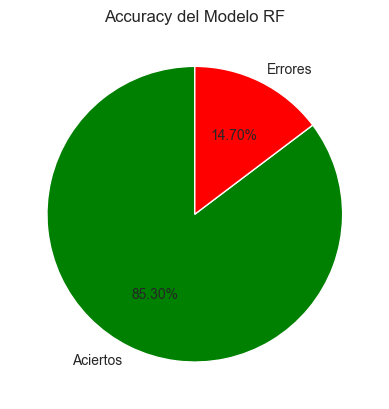

In [54]:
errorf1 = 1 - accuracyrf
plt.pie([accuracyrf * 100, (1 - accuracyrf) * 100], labels=["Aciertos", "Errores"], colors=["green", "red"], autopct="%1.2f%%", startangle=90)
plt.title("Accuracy del Modelo RF")
plt.show()


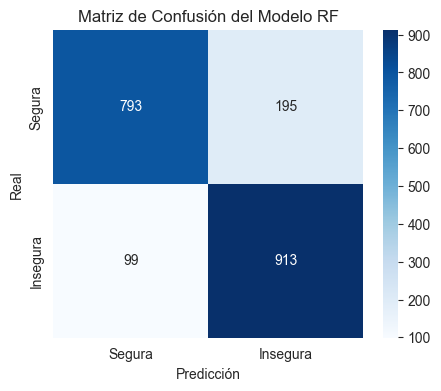

In [55]:
plt.figure(figsize=(5,4))
sns.heatmap(cmrf, annot=True, fmt="d", cmap="Blues", xticklabels=["Segura", "Insegura"], yticklabels=["Segura", "Insegura"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión del Modelo RF")
plt.show()

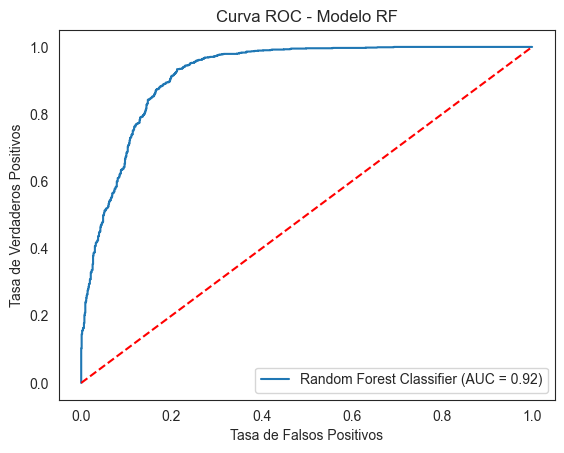

In [56]:
y_probs = modelorf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_aucrf = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Random Forest Classifier (AUC = {roc_aucrf:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Modelo RF")
plt.legend()
plt.show()


---
---

Finalmente, se procede a desarrollar los diferentes modelos supervisados y no supervisados, atendiendo a las variables originales y las creadas a partir del Feature Engineering.   
Como ya he explicado, me centro en las variables relativas a la estructura del enlace por incapacidad de agilizar el acceso desde Streamlit a la web destino del enlace.

### BÚSQUEDA DE LAS MEJORES VARIABLES

In [57]:
df.columns

Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HostnameLength', 'PathLength',
       'QueryLength', 'DoubleSlashInPath', 'CLASS_LABEL', 'SpecialChars',
       'SpecialCharRatio', 'PctNumerics', 'SCHostRatio', 'HostnameRatio',
       'SuspiciousElements', 'AvgPathLength', 'QueryRatio', 'log_UrlLength',
       'log_PathLength', 'log_Querylength'],
      dtype='object')

In [58]:
Seleccion=df[['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash','NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash','NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress','DomainInSubdomains', 'DomainInPaths', 'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
      'SpecialChars', 'SpecialCharRatio', 'PctNumerics','SCHostRatio', 'HostnameRatio', 'SuspiciousElements', 'AvgPathLength','QueryRatio', 'log_UrlLength', 'log_PathLength', 'log_Querylength']]

In [59]:
def calculate_vif(Seleccion):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = Seleccion.columns
    vif_data["VIF"] = [variance_inflation_factor(Seleccion.values, i) for i in range(Seleccion.shape[1])]
    return vif_data

vif_df = calculate_vif(Seleccion)
vif_df.sort_values(by='VIF')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
6,AtSymbol,1.002848e+00
7,TildeSymbol,1.119247e+00
9,NumPercent,1.265246e+00
15,RandomString,3.151023e+00
30,QueryRatio,4.064936e+00
5,NumDashInHostname,4.240098e+00
11,NumAmpersand,8.224465e+00
12,NumHash,1.058172e+01
26,SCHostRatio,1.105753e+01
10,NumQueryComponents,1.221950e+01


In [60]:
Seleccion=df[['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash','NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash','NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress','DomainInSubdomains', 'DomainInPaths', 'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
      'SpecialChars', 'SpecialCharRatio', 'PctNumerics','SCHostRatio', 'HostnameRatio', 'SuspiciousElements','QueryRatio', 'log_UrlLength', 'log_PathLength', 'log_Querylength']]
B=df['CLASS_LABEL']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Seleccion,B)

# Aplicar SelectFromModel con una umbral automático basado en importancia de características
selector = SelectFromModel(clf, prefit=True)
selected_features = Seleccion.columns[selector.get_support()]

print("Variables seleccionadas:", selected_features)

Variables seleccionadas: Index(['NumDots', 'PathLevel', 'UrlLength', 'NumDash', 'NumNumericChars',
       'HostnameLength', 'PathLength', 'SpecialChars', 'SpecialCharRatio',
       'PctNumerics', 'SCHostRatio', 'HostnameRatio', 'log_UrlLength',
       'log_PathLength'],
      dtype='object')


In [61]:
X_trainselect, X_testselect, y_trainselect, y_testselect = train_test_split(Seleccion, B, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier()
model.fit(X_trainselect, y_trainselect)

# Obtener la importancia de las características
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': Seleccion.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

# Selección de características con RFE
rfe = RFE(model, n_features_to_select=10)  # Selecciona las 10 características más importantes
rfe.fit(X_trainselect, y_trainselect)

# Características seleccionadas
selected_features = Seleccion.columns[rfe.support_]
print(selected_features)

               feature  importance
4              NumDash    0.101675
13     NumNumericChars    0.078113
24    SpecialCharRatio    0.072779
0              NumDots    0.071132
2            PathLevel    0.065685
25         PctNumerics    0.063792
31      log_PathLength    0.054419
27       HostnameRatio    0.053662
20          PathLength    0.052273
23        SpecialChars    0.044613
3            UrlLength    0.043517
30       log_UrlLength    0.042576
29          QueryRatio    0.035566
26         SCHostRatio    0.034334
19      HostnameLength    0.033989
32     log_Querylength    0.017307
1       SubdomainLevel    0.016758
8        NumUnderscore    0.016729
10  NumQueryComponents    0.016671
21         QueryLength    0.015816
5    NumDashInHostname    0.013782
28  SuspiciousElements    0.011520
15        RandomString    0.010248
16           IpAddress    0.008526
18       DomainInPaths    0.007331
9           NumPercent    0.005624
11        NumAmpersand    0.004548
17  DomainInSubdomai

Atendiendo al mapa de correlaciones, la tabla de VIF, la recomendación de SFM y la utilidad de las variables y su aplicación posterior en Streamlit, he optado por seleccionar las  siguientes:
- **NumDots** - Cantidad de '.' en la URL, útil para detectar subdominios sospechosos
- **PathLevel** - Cantidad de "/" en la URL, útil para ver la profundidad del path
- **UrlLength** - Versión mas simple que su log. Es util en todo tipo de URL y aporta información para todo tipo de riesgos
- **log_QueryLength** - Versión suavizada de QueryLength, evita alta colinealidad
- **SCHostRatio** - Relación entre caracteres especiales en el hostname, ayuda a detectar estructuras sospechosas
- **NumQueryComponents** - Suma de "&" y "=", clave en URLs con muchos parámetros
- **QueryRatio** - Tiene un VIF moderado y aporta detalles sobre la parte final del URL.
- **NumNumericChars** - Contar el número de valores numéricos aporta información importante acerca de la fiabilidad del enlace.
- **DomainInPaths** - Detecta si el dominio se repite en la ruta, comportamiento típico en URLs engañosas
- **HostnameLength** - Longitud del hostname, indicativo de URLs anómalas)


Con estas puedo analizar dominios sospechosos, Hosts extraños y estructuras anómalas, que me permiten no solo detectar posible phishing el objetivo original del dataset), sino tambien otras fronteras de peligro como un posible tracking, spam, malware u otros riesgos cibernéticos.   
Además, voy a mantener como preseleccionada **SuspiciousElements**, que pueden ser útiles en esta investigación, y voy a ejecutar una validación cruzada y un SHAP para ver su relevancia.

In [62]:
Xoriginal= df[['NumDash','NumDots','NumDashInHostname','UrlLength','NumQueryComponents','IpAddress','DomainInSubdomains', 'DomainInPaths','HostnameLength', 'PathLevel']]
variables_allstar = ['NumDots', 'PathLevel', 'UrlLength','log_Querylength','SCHostRatio', 'NumQueryComponents', 'QueryRatio','DomainInPaths', 'HostnameLength']
X1 = df[variables_allstar]
X2 = df[variables_allstar + ['SuspiciousElements']]

y=df['CLASS_LABEL']

#### CROSS VALIDATION Y FEATURE IMPORTANCE PARA DETERMINAR QUE SELECIÓN ES MAS EFICÁZ

Para ello, antes tengo que formar un modelo con el que comprobar la relevancia de las features. Lo voy a entrenar con todas las variables (X2) pues considero que para determinar la adicion de esas dos resulta mas util entrenarlo en un modelo con ellas.

In [63]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X2, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(Xoriginal, y, test_size=0.2, random_state=42, stratify=y)



He buscado como encontrar rapidamente una lista con las variables mas eficaces. Me he peleado demaiado y sin muchos resultados útiles.

In [64]:
# # Ajustar modelo inicial con GridSearch
# rf = RandomForestClassifier(random_state=42)
# param_grid = {
#     "n_estimators": [100,200,300],  
#     "max_depth": [12,15,20],  
#     "min_samples_split": [5, 10],  
#     "min_samples_leaf": [2, 3, 5], 
#     "bootstrap": [True, False]  
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=False, scoring="accuracy")
# grid_search.fit(Xs_train, ys_train)

# print("Mejores hiperparámetros:", grid_search.best_params_)
# best_rf = grid_search.best_estimator_

# selector = SelectFromModel(best_rf, threshold="median", prefit=True)

# X_train_selected = selector.transform(Xs_train)
# X_test_selected = selector.transform(Xs_test)

# # Nuevo GridSearch para el modelo reducido
# grid_search_selected = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=False, scoring="accuracy")
# grid_search_selected.fit(X_train_selected, ys_train)

# print("Mejores hiperparámetros después de Feature Selection:", grid_search_selected.best_params_)
# best_rf_selected = grid_search_selected.best_estimator_

# # Evaluación final
# preds_selected = best_rf_selected.predict(X_test_selected)
# final_accuracy = accuracy_score(ys_test, preds_selected)

# print(f"Accuracy después de Feature Selection: {final_accuracy:.4f}")


In [65]:
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# # Obtener la importancia de las características
# importances = model.feature_importances_
# feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
# feature_importances = feature_importances.sort_values(by='importance', ascending=False)
# print(feature_importances)

# # Selección de características con RFE
# rfe = RFE(model, n_features_to_select=10)  # Selecciona las 10 características más importantes
# rfe.fit(X_train, y_train)

# # Características seleccionadas
# selected_features = X.columns[rfe.support_]
# print(selected_features)

In [66]:
# # Obtener el soporte de las variables seleccionadas (True = seleccionada, False = descartada)
# selected_features_mask = selector.get_support()

# # Obtener los nombres de las variables seleccionadas
# selected_features = np.array(Xs_train.columns)[selected_features_mask]

# print("Variables seleccionadas después de Feature Selection:")
# print(selected_features)

# # Crear un DataFrame con las importancias de las características
# feature_importances = pd.DataFrame({
#     "Feature": Xs_train.columns,
#     "Importance": best_rf.feature_importances_
# })

# # Filtrar solo las variables seleccionadas
# selected_importances = feature_importances[selected_features_mask]

# # Ordenarlas de mayor a menor importancia
# selected_importances = selected_importances.sort_values(by="Importance", ascending=False)

# print(selected_importances)



In [67]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [100,200,300],  
    "max_depth": [12,15,20],  
    "min_samples_split": [5, 10],  
    "min_samples_leaf": [2, 3, 5], 
    "bootstrap": [True, False]  
}
# grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,n_jobs=-1, verbose=False,  scoring="accuracy")
# grid_search.fit(Xs_train, ys_train)
# print("Mejores hiperparametros:", grid_search.best_params_)
# best_rf = grid_search.best_estimator_
# prediccionss = best_rf.predict(Xs_test)
# accuracy_score(ys_test, prediccionss)

#Lo dejo comentado porque ya tengo sus resultados y demora mucho en ejecutarse.

In [68]:
modelRFs=RandomForestClassifier(max_depth=20,
                            n_estimators=300,
                            min_samples_leaf=2,
                            bootstrap=True,
                            min_samples_split=5)

modelRFs.fit(Xs_train,ys_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Definimos los scorers
f1_scorer = make_scorer(f1_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)

# Realizamos la validación cruzada para cada conjunto de variables y obtenemos los resultados
scores_original_acc = cross_val_score(modelorf, Xoriginal, y, cv=5, scoring='accuracy')
scores_base_acc = cross_val_score(modelRFs, X1, y, cv=5, scoring='accuracy')
scores_full_acc = cross_val_score(modelRFs, X2, y, cv=5, scoring='accuracy')

scores_original_f1 = cross_val_score(modelorf, Xoriginal, y, cv=5, scoring=f1_scorer)
scores_base_f1 = cross_val_score(modelRFs, X1, y, cv=5, scoring=f1_scorer)
scores_full_f1 = cross_val_score(modelRFs, X2, y, cv=5, scoring=f1_scorer)

scores_original_precision = cross_val_score(modelorf, Xoriginal, y, cv=5, scoring=precision_scorer)
scores_base_precision = cross_val_score(modelRFs, X1, y, cv=5, scoring=precision_scorer)
scores_full_precision = cross_val_score(modelRFs, X2, y, cv=5, scoring=precision_scorer)

scores_original_recall = cross_val_score(modelorf, Xoriginal, y, cv=5, scoring=recall_scorer)
scores_base_recall = cross_val_score(modelRFs, X1, y, cv=5, scoring=recall_scorer)
scores_full_recall = cross_val_score(modelRFs, X2, y, cv=5, scoring=recall_scorer)

# Imprimimos los resultados
print(f"Accuracy con las variables pre FE: {scores_original_acc.mean():.4f}")
print(f"Accuracy sin ellas: {scores_base_acc.mean():.4f}")
print(f"Accuracy con ellas: {scores_full_acc.mean():.4f}")

print(f"F1 con las variables pre FE: {scores_original_f1.mean():.4f}")
print(f"F1 sin ellas: {scores_base_f1.mean():.4f}")
print(f"F1 con ellas: {scores_full_f1.mean():.4f}")

print(f"Precision con las variables pre FE: {scores_original_precision.mean():.4f}")
print(f"Precision sin ellas: {scores_base_precision.mean():.4f}")
print(f"Precision con ellas: {scores_full_precision.mean():.4f}")

print(f"Recall con las variables pre FE: {scores_original_recall.mean():.4f}")
print(f"Recall sin ellas: {scores_base_recall.mean():.4f}")
print(f"Recall con ellas: {scores_full_recall.mean():.4f}")


Accuracy con las variables pre FE: 0.7930
Accuracy sin ellas: 0.7491
Accuracy con ellas: 0.7434
F1 con las variables pre FE: 0.8102
F1 sin ellas: 0.7586
F1 con ellas: 0.7583
Precision con las variables pre FE: 0.7699
Precision sin ellas: 0.7421
Precision con ellas: 0.7417
Recall con las variables pre FE: 0.8610
Recall sin ellas: 0.7974
Recall con ellas: 0.7892


Y tras todo el Feature Engineering y la selección de las mejores variables entre las originales y las creadas, se observa que el modelo original con las variables originales tiene un mejor Cross Validation Score en todas sus métricas de media.   Se ve tambien que el mismo modelo, que habia sido entrenado con SuspiciousElements, obtiene un accuracy mejor en CV cuando se realiza sobre un grupo de variables que no la incluyen, por lo que queda descartada. Para asegurarme de que grupo de variables.

Por tanto, el trabajo del FE se mantiene pero queda un poco en vano, pues es evidente que el grupo de variables mas eficaz es el seleccionado originalmente.

---

Una vez ha quedado comprobado que las variables originales son las mas precisas, queda desarrollar y analizar otros modelos de diferentes tipos y tratar de ver si alguno de los ejecutados mejora los resultados del MODELRF1 original. Como es debido, el "mejor" modelo será el seleccionado para la aplicación práctica del Proyecto en Streamlit.

A continuación se desarrollan, en adición al Random Forest con Pipeline ya elaborado, cuatro Modelos Supervisados: 
- Un Logistic Regression Classifier
- Un Arbol de Decisión
- Un Modelo de KNN
- Un Modelo de SVM
- Un Modelo de XGBoost Classifier


In [70]:
X=df[['NumDash','NumDots','NumDashInHostname','UrlLength','NumQueryComponents','IpAddress','DomainInSubdomains', 'DomainInPaths','HostnameLength', 'PathLevel']]
y=df['CLASS_LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_trains=scaler.fit_transform(X_train)
X_tests=scaler.fit_transform(X_test)

---

## 2. **MODEL-LR** - LOGISTIC REGRESSION CLASSIFIER 

In [71]:
### REGRESIÓN LOGÍSTICA ###
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  
    ('model', LogisticRegression())
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear']},
             scoring='accuracy')

In [72]:
best_lr = grid_lr.best_estimator_
y_predlr = best_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_predlr)
precision_lr = precision_score(y_test, y_predlr)
recall_lr = recall_score(y_test, y_predlr)
f1_lr = f1_score(y_test, y_predlr)

print("Best Params:", grid_lr.best_params_)
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1-score:", f1_lr)
print("\nClassification Report:\n", classification_report(y_test, y_predlr))

Best Params: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Accuracy: 0.8265
Precision: 0.7992799279927992
Recall: 0.8774703557312253
F1-score: 0.8365520489872822

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.82       988
           1       0.80      0.88      0.84      1012

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



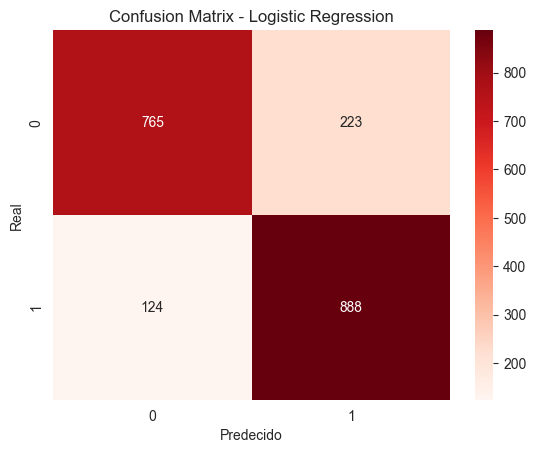

In [73]:
cmlr = confusion_matrix(y_test, y_predlr)
sns.heatmap(cmlr, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predecido")
plt.ylabel("Real")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

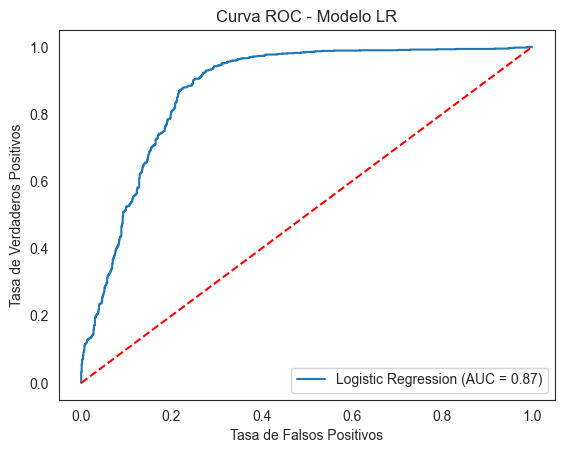

In [74]:
y_probslr = best_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probslr)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Modelo LR")
plt.legend()
plt.show()


---

## 3. **MODEL_DT** - ARBOL DE DECISIÓN

In [75]:
pipeline_dt = Pipeline([
    ('model', DecisionTreeClassifier())
])

param_grid_dt = {
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [76]:
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)  
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt) 
f1_dt = f1_score(y_test, y_pred_dt)

print("Mejores Parametros:", grid_dt.best_params_) 
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-score:", f1_dt)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))


Mejores Parametros: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Accuracy: 0.8355
Precision: 0.8003518029903254
Recall: 0.8992094861660079
F1-score: 0.8469055374592834

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82       988
           1       0.80      0.90      0.85      1012

    accuracy                           0.84      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.84      0.83      2000



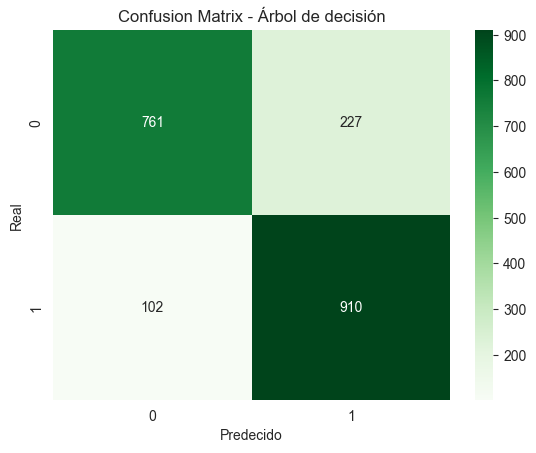

In [77]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, cmap="Greens", fmt="d")
plt.xlabel("Predecido")
plt.ylabel("Real")
plt.title("Confusion Matrix - Árbol de decisión")
plt.show()


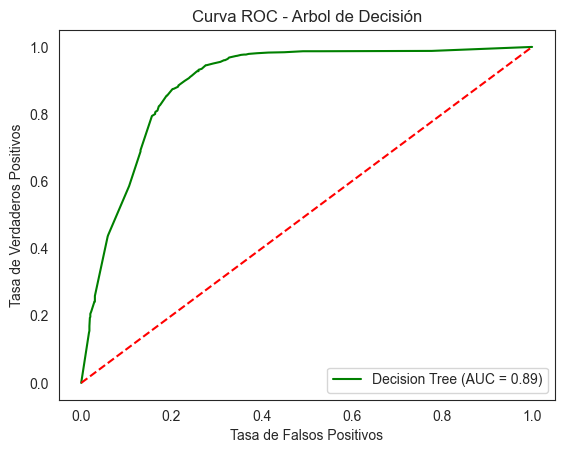

In [78]:
y_probsdt = best_dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probsdt)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Arbol de Decisión")
plt.legend()
plt.show()

---

## 4. **MODEL_KNN** - K-NEAREST NEIGHBOURS

In [79]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__metric': ['euclidean', 'manhattan'],
                         'model__n_neighbors': [3, 5, 7, 9],
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [80]:
best_knn = grid_knn.best_estimator_
y_predknn = best_knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_predknn)
precision_knn = precision_score(y_test, y_predknn)
recall_knn = recall_score(y_test, y_predknn)
f1_knn = f1_score(y_test, y_predknn)

print("Best Params:", grid_knn.best_params_)
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_knn)
print("\nClassification Report:\n", classification_report(y_test, y_predknn))

Best Params: {'model__metric': 'manhattan', 'model__n_neighbors': 9, 'model__weights': 'uniform'}
Accuracy: 0.8325
Precision: 0.8041329739442947
Recall: 0.8843873517786561
F1-score: 0.8423529411764706

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82       988
           1       0.80      0.88      0.84      1012

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



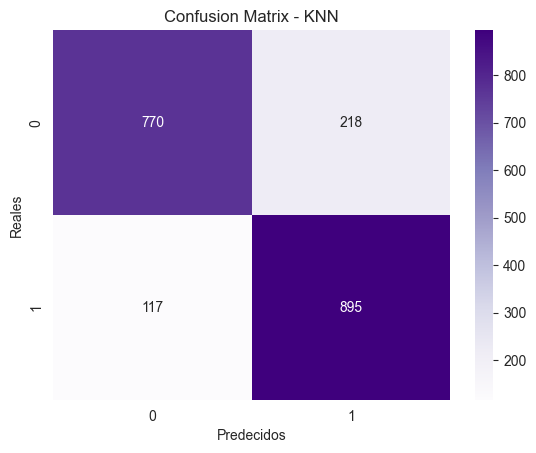

In [81]:
sns.heatmap(confusion_matrix(y_test, y_predknn), annot=True, cmap="Purples", fmt="d")
plt.xlabel("Predecidos")
plt.ylabel("Reales")
plt.title("Confusion Matrix - KNN")
plt.show()

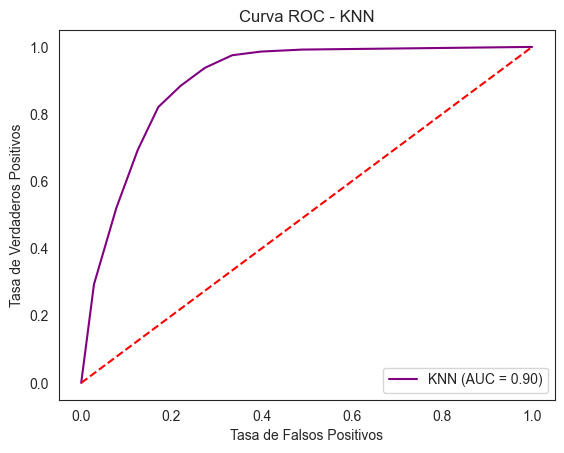

In [82]:
y_probsknn = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probsknn)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})', color='purple')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - KNN")
plt.legend()
plt.show()


---

## 5. **MODEL_SVM**

In [83]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(probability=True))])

param_grid_svm = {
    'model__C': [1], #0.1,1,10
    'model__kernel': ['linear'],
    'model__gamma': ['auto'] #AUTO,SCALAR
}
#Se demoraba demasiado en hacer GS con una gama de parametros, por lo que lo he probado uno por uno hasta encontrar la combinacion con mejores resultado
# Si, haciendolo asi podia haber hecho el modelo sin gs. 
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, n_jobs=-1, scoring='accuracy')
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'model__C': [1], 'model__gamma': ['auto'],
                         'model__kernel': ['linear']},
             scoring='accuracy')

In [84]:
best_svm = grid_svm.best_estimator_
y_predsvm = best_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_predsvm)
precision_svm = precision_score(y_test, y_predsvm)
recall_svm = recall_score(y_test, y_predsvm)
f1_svm = f1_score(y_test, y_predsvm)

print("Best Params:", grid_svm.best_params_)
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_svm)
print("\nClassification Report:\n", classification_report(y_test, y_predsvm))

Best Params: {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'linear'}
Accuracy: 0.8265
Precision: 0.7768526228143214
Recall: 0.9219367588932806
F1-score: 0.8431992769995481

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81       988
           1       0.78      0.92      0.84      1012

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.82      2000
weighted avg       0.84      0.83      0.82      2000



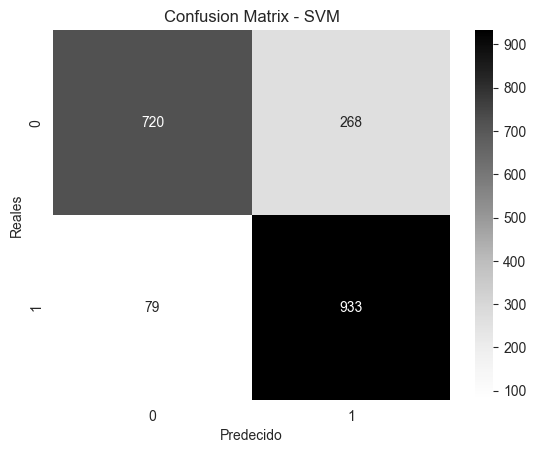

In [85]:
sns.heatmap(confusion_matrix(y_test, y_predsvm), annot=True, cmap="Greys", fmt="d")
plt.xlabel("Predecido")
plt.ylabel("Reales")
plt.title("Confusion Matrix - SVM")
plt.show()

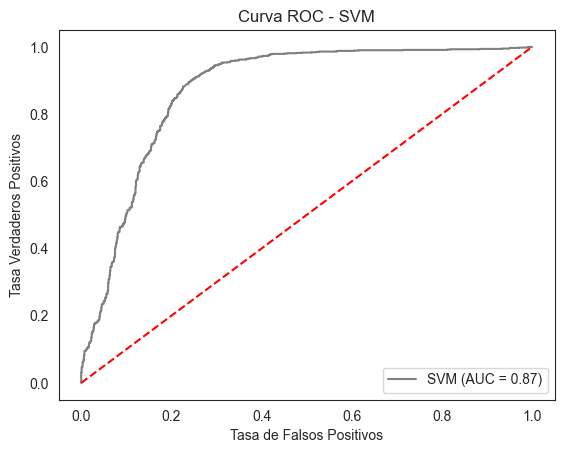

In [86]:
y_probssvm = best_svm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probssvm)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})', color='grey')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa Verdaderos Positivos")
plt.title("Curva ROC - SVM")
plt.legend()
plt.show()


---

## 7. **MODEL_HGB** - HISTGRADIENT BOOSTING CLASSIFIER

In [87]:
pipeline_hgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', HistGradientBoostingClassifier())
])

param_grid_hgb = {
    'model__max_iter': [100, 200, 500], 
    'model__learning_rate': [0.01, 0.1, 0.5], 
    'model__max_depth': [3, 5, 10]
}

grid_hgb = GridSearchCV(pipeline_hgb,param_grid_hgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_hgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        HistGradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.5],
                         'model__max_depth': [3, 5, 10],
                         'model__max_iter': [100, 200, 500]},
             scoring='accuracy')

In [88]:
best_hgb = grid_hgb.best_estimator_
y_predhgb = best_hgb.predict(X_test)

accuracy_hgb = accuracy_score(y_test, y_predhgb)
precision_hgb = precision_score(y_test, y_predhgb)
recall_hgb = recall_score(y_test, y_predhgb)
f1_hgb = f1_score(y_test, y_predhgb)

print("Best Params:", grid_hgb.best_params_)
print("Accuracy:", accuracy_hgb)
print("Precision:", precision_hgb)
print("Recall:", recall_hgb)
print("F1-score:", f1_hgb)
print("\nClassification Report:\n", classification_report(y_test, y_predhgb))

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__max_iter': 100}
Accuracy: 0.856
Precision: 0.8237924865831843
Recall: 0.9100790513833992
F1-score: 0.8647887323943662

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       988
           1       0.82      0.91      0.86      1012

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



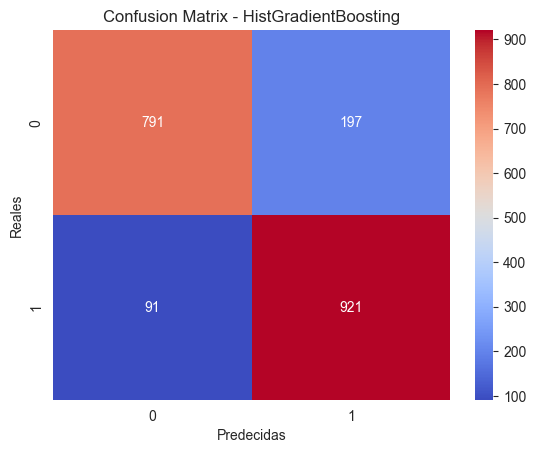

In [89]:
sns.heatmap(confusion_matrix(y_test, y_predhgb), annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Predecidas")
plt.ylabel("Reales")
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()

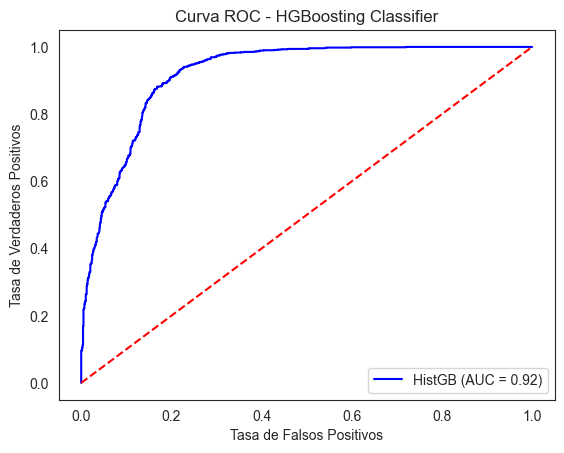

In [90]:
y_probshgb = best_hgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probshgb)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'HistGB (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - HGBoosting Classifier")
plt.legend()
plt.show()

---

## 7. XGBOOST X

Debido a problemas con Libomp (una libreria que usa tanto XGBoost como LightBoost), no he podido desarrollar este modelo.

In [91]:
# pipeline_xgb = Pipeline([
#     ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
# ])

# param_grid_xgb = {
#     'model__n_estimators': [50, 100, 200],
#     'model__max_depth': [3, 5, 7],
#     'model__learning_rate': [0.01, 0.1, 0.2]
# }

# grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='accuracy')
# grid_xgb.fit(X_train, y_train)

# best_xgb = grid_xgb.best_estimator_
# y_pred = best_xgb.predict(X_test)

# print("Best Params:", grid_xgb.best_params_)
# print("Accuracy:", best_xgb.score(X_test, y_test))
# print(classification_report(y_test, y_pred))


---
---

## 4.3 **MODEL_PCA** - MODELO NO SUPERVISADO - ANÁLISIS DE COMPONENTES PRINCIPALES

A continuación se desarrolla el Modelo No Supervisado . He tratado de ejecutar un PCA (con mucha ayuda de compañeros y de otras fuentes), para obtener el mejor número de componentes principales en funcion de la Varianza acumulada, visualizándola y mostrando la matriz de Confusión para cada uno de los componentes y variables seleccionadas.

In [92]:
# ---- Escalar los datos antes del PCA ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# ---- Encontrar el mejor número de componentes basado en la varianza acumulada ----
pca = PCA()
X_pca_all = pca.fit_transform(X_scaled)

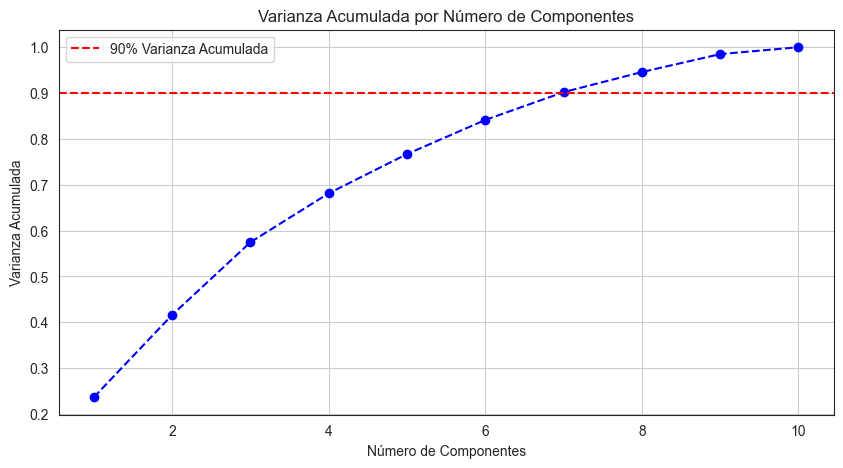

In [93]:
# Calcular la varianza acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficar la varianza acumulada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='o', linestyle='--', color='b')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza Acumulada')  # Línea de referencia
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Acumulada por Número de Componentes')
plt.legend()
plt.grid()
plt.show()

Mejor número de componentes principales: 7


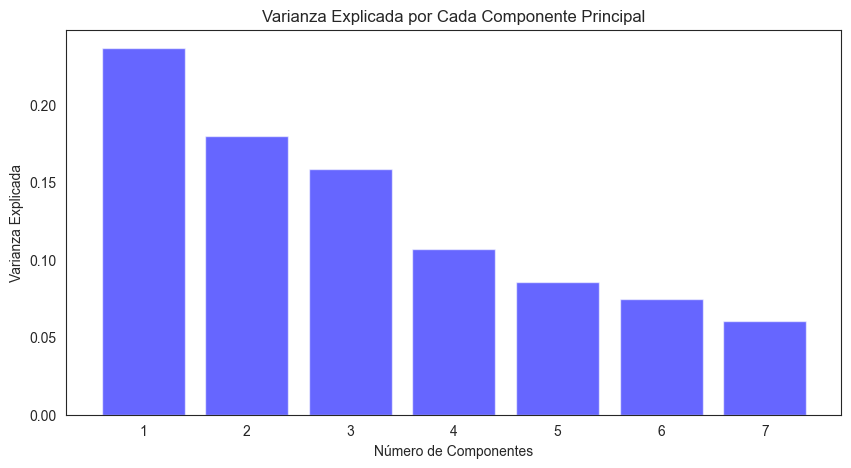

In [94]:
n_componentes_optimos = np.argmax(varianza_acumulada >= 0.90) + 1
print(f"Mejor número de componentes principales: {n_componentes_optimos}")

# ---- Aplicar PCA con el número óptimo de componentes ----
pca_final = PCA(n_components=n_componentes_optimos)
X_pca = pca_final.fit_transform(X_scaled)

# Graficar la varianza explicada por cada componente
plt.figure(figsize=(10, 5))
plt.bar(range(1, n_componentes_optimos + 1), pca_final.explained_variance_ratio_, color='b', alpha=0.6)
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Cada Componente Principal')
plt.show()

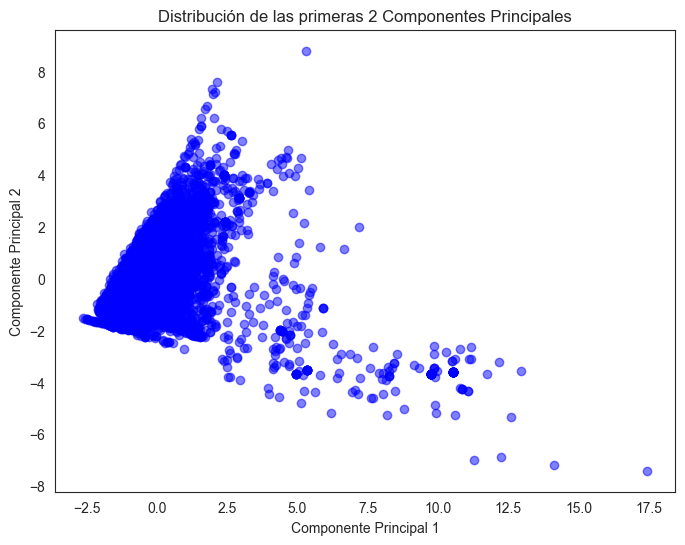

In [95]:
# ---- Visualización de las primeras 2 componentes principales ----
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color='b')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Distribución de las primeras 2 Componentes Principales')
plt.show()

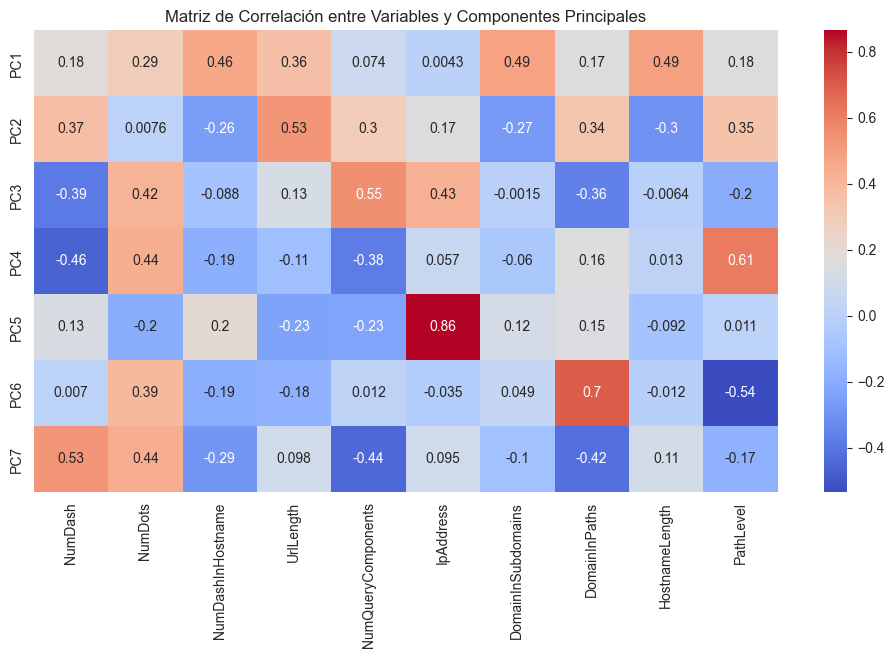

In [96]:
# ---- Matriz de correlación entre variables originales y componentes principales ----
pca_components = pd.DataFrame(pca_final.components_, columns=X.columns, 
                              index=[f'PC{i+1}' for i in range(n_componentes_optimos)])

plt.figure(figsize=(12, 6))
sns.heatmap(pca_components, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación entre Variables y Componentes Principales")
plt.show()

In [97]:
# ---- Aplicar K-Means sobre los datos transformados con PCA ----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Calcular el silhouette score
silhouette = silhouette_score(X_pca, clusters)
print(f"Silhouette Score del clustering: {silhouette:.4f}")

Silhouette Score del clustering: 0.3028


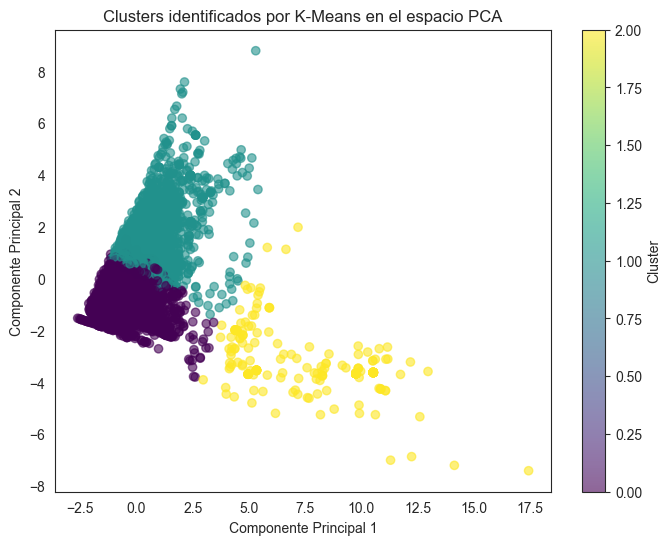

In [98]:
# Visualizar los clusters en las primeras dos componentes principales
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters identificados por K-Means en el espacio PCA')
plt.colorbar(label='Cluster')
plt.show()


---

Una vez obtenido el numero óptimo de componentes, y entrenado el KMeans sobre lo obtenido con PCA, se entrena el mejor modelo que he conseguido hasta ahora con los datos transformados para ver si mejora los resultados conseguidos. Debo decir que, en caso de que lo mejore, creo que mantendré como modelo definitivo el RF ya elaborado, pues el PCA no acabo de comprenderlo muy bien y he necesitado mucha ayuda (como es visible) para tratar de entenderlo y desarrollarlo.

In [99]:
best_model = modelorf  # modelo original sin PCA, el mejor modelo entrenado

# --- Copiar el modelo original para entrenarlo con PCA ---
modelorf_pca = best_model.__class__()  # Crear una nueva instancia del modelo


In [100]:
# --- Aplicar el PCA con el número óptimo de componentes ---
pca_final = PCA(n_components=n_componentes_optimos)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# --- Entrenar la copia del modelo con los datos transformados ---
modelorf_pca.fit(X_train_pca, y_train)

RandomForestClassifier()

In [101]:
# --- Calcular la Accuracy ---
y_predpca = modelorf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_predpca)
precision_pca = precision_score(y_test, y_predpca)
recall_pca = recall_score(y_test, y_predpca)
f1_pca = f1_score(y_test, y_predpca)

# Imprimir las métricas
print('Accuracy con PCA: {:.2f}'.format(accuracy_pca))
print('Precision con PCA: {:.2f}'.format(precision_pca))
print('Recall con PCA: {:.2f}'.format(recall_pca))
print('F1-Score con PCA: {:.2f}'.format(f1_pca))

Accuracy con PCA: 0.84
Precision con PCA: 0.81
Recall con PCA: 0.89
F1-Score con PCA: 0.85


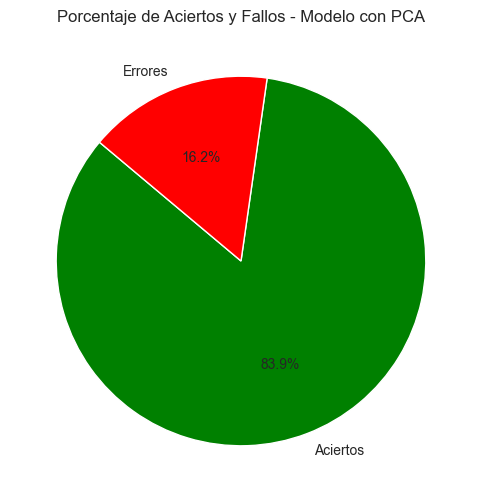

In [102]:
# --- Graficar el porcentaje de aciertos y fallos ---
plt.figure(figsize=(6,6))
labels = ['Aciertos', 'Errores']
values = [accuracy_pca, 1 - accuracy_pca]
colors = ['green', 'red']
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Porcentaje de Aciertos y Fallos - Modelo con PCA")
plt.show()

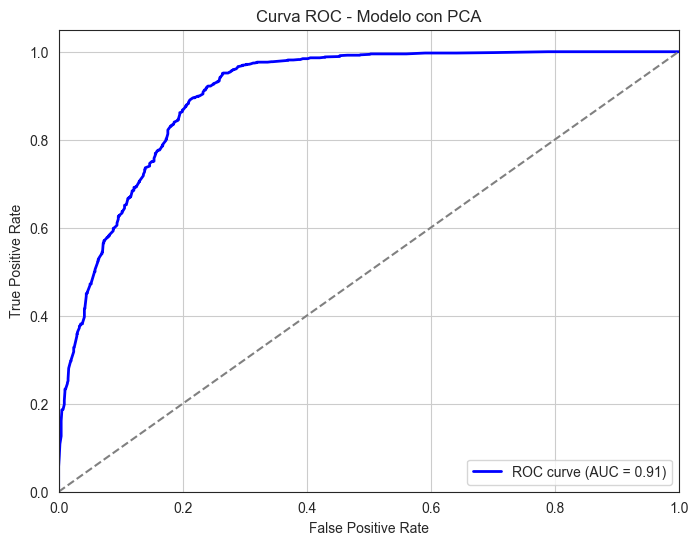

In [103]:
y_pred_proba_pca = modelorf_pca.predict_proba(X_test_pca)[:, 1]  # Probabilidad de clase positiva (1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)

# --- Graficar la curva ROC ---
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo con PCA')
plt.legend(loc="lower right")
plt.grid()
plt.show()

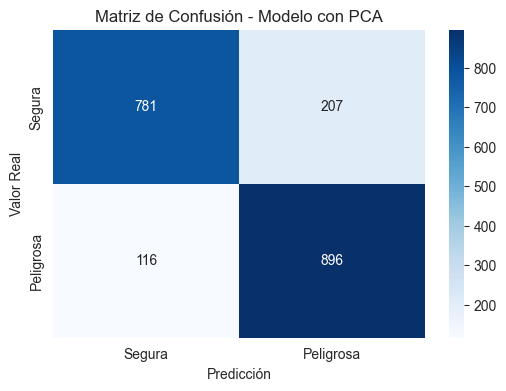

In [104]:
# --- Calcular la Matriz de Confusión ---
cmpca = confusion_matrix(y_test, y_predpca)

# --- Graficar la Matriz de Confusión ---
plt.figure(figsize=(6,4))
sns.heatmap(cmpca, annot=True, fmt="d", cmap="Blues", xticklabels=['Segura', 'Peligrosa'], yticklabels=['Segura', 'Peligrosa'])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Modelo con PCA")
plt.show()


---
---
---

# 5. EVALUACIÓN GENERAL DE MODELOS

In [1]:
metrics_= {
    'MODELO': ['Total-Logistic Regression', 'RANDOM FOREST', 'Logistic Regressor', 'Arbol de Decisión', 'K-Nearest Neighbours', 'Support Vector Machine', 'HistGradient Boosting', 'Principal Components Analysis'],
    'Accuracy': [accuracyt1, accuracyrf, accuracy_lr, accuracy_dt, accuracy_knn, accuracy_svm, accuracy_hgb, accuracy_pca],
    'Precision': [precisiont1, precisionrf, precision_lr, precision_dt, precision_knn, precision_svm, precision_hgb, precision_pca],
    'Recall': [recallt1, recallrf, recall_lr, recall_dt, recall_knn, recall_svm, recall_hgb, recall_pca],
    'F1 Score': [f1t1, f1rf, f1_lr, f1_dt, f1_knn, f1_svm, f1_hgb, f1_pca]}

# Convertir el diccionario en un DataFrame
df_metrics = pd.DataFrame(metrics_).set_index('MODELO').sort_values('F1 Score',ascending=False)

# Mostrar el DataFrame
df_metrics

NameError: name 'accuracyt1' is not defined

## 6. DESCARGA DE MODELOS

In [105]:
#MODELRF1
#EL MODELO DE RF ORIGINAL SOLO CON LAS MEJORES VARIABLES ORIGINALES RELATIVAS A LA ESTRUCTURA
with open("../models/final_model.pkl", "wb") as model_file:
    pickle.dump(modelorf, model_file)

In [106]:
#MODELT1 - EL MODELO CON LAS MEJORES VARIABLES DEL DATASET ORIGINAL (INCLUYENDO LLAMADAS A LA WEB)
with open("../models/trained_model_1t.pkl", "wb") as model_file:
    pickle.dump(modelt1, model_file)

In [107]:
with open("../models/trained_model_2lr.pkl", "wb") as model_file:
    pickle.dump(best_lr, model_file)

In [108]:
with open("../models/trained_model_3dt.pkl", "wb") as model_file:
    pickle.dump(best_dt, model_file)

In [109]:
with open("../models/trained_model_4knn.pkl", "wb") as model_file:
    pickle.dump(best_knn, model_file)

In [110]:
with open("../models/trained_model_5svm.pkl", "wb") as model_file:
    pickle.dump(best_svm, model_file)

In [111]:
with open("../models/trained_model_6pca.pkl", "wb") as model_file:
    pickle.dump(modelorf_pca, model_file)

In [114]:
print('THE END')

THE END
